# Librairies

In [2]:
library('igraph')
library('orca') 
require(ggplot2)
require(reshape2) 
library(dplyr)

# Data Description

In [48]:
#Read the data from a csv
rm(datafile)
datafile <- read.csv2("mentions_datafile.csv")

#change column names
colnames(datafile) <- c("creation_date","user1","user2","time_interval","frequency")
head(datafile)


,creation_date,user1,user2,time_interval,frequency
,<fct>,<dbl>,<dbl>,<int>,<int>
1,2019-10-28 00:00:00,"1,111153e+08","2,222890e+09",436727,1
2,2019-10-28 00:00:00,"1,111153e+08","2,222991e+06",436727,1
3,2019-10-28 01:00:00,"1,111155e+08","2,222032e+07",436728,1
4,2019-10-28 03:00:00,"1,111715e+17","2,222607e+18",436730,1
5,2019-10-28 03:00:00,"1,111715e+17","2,222626e+07",436730,1
6,2019-10-28 03:00:00,"1,111715e+17","2,222043e+09",436730,1


# Count number of interactions between entities, per date

## Count corresponding interactions

In [49]:
count_interactions <- plyr::count(datafile, "creation_date")

#change column names
colnames(count_interactions) <- c("creation_date", "nb_interactions")

#print order by datee
tail(count_interactions[order(count_interactions$creation_date),])

,creation_date,nb_interactions
,<fct>,<int>
64,2019-10-30 18:00:00,542
65,2019-10-30 19:00:00,532
66,2019-10-30 20:00:00,400
67,2019-10-30 21:00:00,340
68,2019-10-30 22:00:00,249
69,2019-10-30 23:00:00,145


# Time series

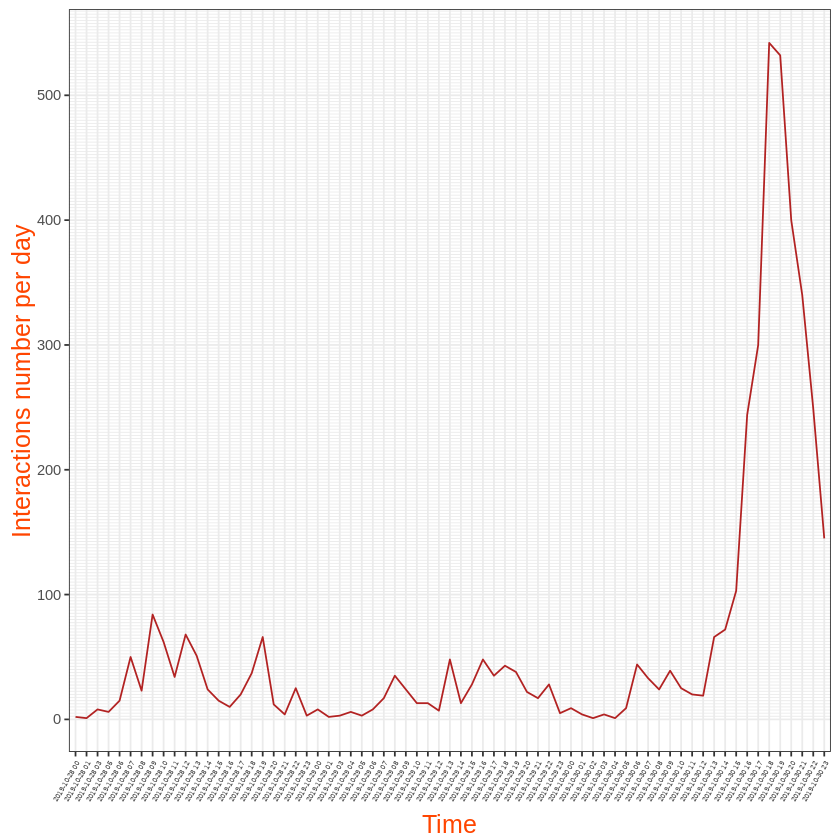

In [50]:
theme_set(theme_bw())

ggplot(count_interactions, aes(substr(creation_date,1,13), nb_interactions, group = 1)) + 
  geom_line(color="firebrick")+
labs(x="Time", y="Interactions number per day") +

 theme(axis.text.x=element_text(angle=60, hjust=1,size = rel(0.5))) +
theme(axis.title.x = element_text(color = "orangered",
                                    size = 15, vjust = -0.35),
        axis.title.y = element_text(color = "orangered",
                                    size = 15, vjust = 0.35))+
  scale_y_continuous(breaks = seq(0, 700, 100),
                     minor_breaks = seq(0, 5000, 2.5))  


# Preliminary graphlet counting functions

In [12]:
graph_to_indexed_edges <- function(graph) {
  # Use igraph method to get edge list with edges specified using vertex ID 
  # (indexes) rather than names
  edges <- igraph::get.edgelist(graph, names = FALSE)
  # Convert edge list from numeric to integer
  edges <- structure(vapply(edges, as.integer, integer(1)), dim = dim(edges))
  colnames(edges) <- c("Node A index", "Node B index")
  node_vertex_names <- igraph::get.vertex.attribute(graph, name = "name")
  attr(edges, "vertex_names") <- node_vertex_names
  return(edges)
}


orbit_key <- function(max_graphlet_size) {
  if(max_graphlet_size == 2) {
    node_count <- c(2)
  } else if(max_graphlet_size == 3) {
    node_count <- c(2, rep(3,3))
  } else if(max_graphlet_size == 4) {
    node_count <- c(2, rep(3,3), rep(4,11))
  } else if (max_graphlet_size == 5) {
    node_count <- c(2, rep(3,3), rep(4,11), rep(5, 58))
  } else {
    stop("Unsupported maximum graphlet size")
  }
  max_node_index <- length(node_count)-1
  id <- purrr::simplify(purrr::map(0:max_node_index, function(index) {
    paste('O', index, sep = "")}))
  name <- 
    return(list(max_nodes = max_graphlet_size, id = id, node_count = node_count))
}


count_orbits_per_node <- function(graph, max_graphlet_size) {
  if(max_graphlet_size == 4) {
    orca_fn <- orca::count4
  } else if(max_graphlet_size == 5) {
    orca_fn <- orca::count5
  } else {
    stop("Unsupported maximum graphlet size")
  }
  indexed_edges <- graph_to_indexed_edges(graph)
  num_edges <- dim(indexed_edges)[[1]]
  if(num_edges >= 1) {
    orbit_counts <- orca_fn(indexed_edges)
  } else {
    # ORCA functions expect at least one edge, so handle this case separately
    # and manually construct empty orbit count matrix
    orbit_ids <- orbit_key(max_graphlet_size)$id
    num_orbits <- length(orbit_ids)
    num_nodes <- igraph::vcount(graph)
    orbit_counts <- matrix(0, nrow = num_nodes, ncol = num_orbits)
    colnames(orbit_counts) <- orbit_ids
  }
  rownames(orbit_counts) <- igraph::get.vertex.attribute(graph, name = "name")
  return(orbit_counts)
}


graphlet_key <- function(max_graphlet_size) {
  if(max_graphlet_size == 2) {
    node_count <- c(2)
  } else if(max_graphlet_size == 3) {
    node_count <- c(2, rep(3,2))
  } else if(max_graphlet_size == 4) {
    node_count <- c(2, rep(3,2), rep(4,6))
  } else if (max_graphlet_size == 5) {
    node_count <- c(2, rep(3,2), rep(4,6), rep(5, 21))
  } else {
    stop("Unsupported maximum graphlet size")
  }
  max_node_index <- length(node_count)-1
  id <- purrr::simplify(purrr::map(0:max_node_index, function(index) {
    paste('G', index, sep = "")}))
  name <- 
    return(list(max_nodes = max_graphlet_size, id = id, node_count = node_count))
}



orbit_to_graphlet_counts <- function(orbit_counts) {
  num_orbits <- dim(orbit_counts)[2]
  # Indexes to select the orbit(s) that comprise each graphlet. Note that we 
  # define these in the zero-based indexing used in journal papers, but 
  # need to add 1 to convert to the 1-based indexing used by R
  if(num_orbits == 15) {
    # Orbits for graphlets comprising up to 4 nodes
    max_nodes <- 4
    orbit_to_graphlet_map <- 
      purrr::map(list(0, 1:2, 3, 4:5, 6:7, 8, 9:11, 12:13, 14), 
                 function(indexes){ indexes + 1})
  } else if(num_orbits == 73) {
    # Orbits for graphlets comprising up to 5 nodes
    max_nodes <- 5
    orbit_to_graphlet_map <- 
      purrr::map(list(0, 1:2, 3, 4:5, 6:7, 8, 9:11, 12:13, 14, 15:17, 18:21, 
                      22:23, 24:26, 27:30, 31:33, 34, 35:38, 39:42, 43:44, 
                      45:48, 49:50, 51:53, 54:55, 56:58, 59:61, 62:64, 
                      65:67, 68:69, 70:71, 72), 
                 function(indexes){ indexes + 1})
  } else {
    stop(("Unsupported number of orbits"))
  }
  # Sum counts across orbits in graphlets
  graphlet_counts <- sapply(orbit_to_graphlet_map, function(indexes){
    rowSums(orbit_counts[,indexes, drop = FALSE])})
  if(dim(orbit_counts)[[1]] == 1) {
    # If orbit counts has only a single row, sapply returns a vector
    # rather than a matrix, so convert to a matrix by adding dim
    dim(graphlet_counts) <- c(1, length(graphlet_counts))
  }
  # Add graphlet names
  colnames(graphlet_counts) <- graphlet_key(max_nodes)$id
  return(graphlet_counts)
}
  
count_graphlets_per_node <- function(graph, max_graphlet_size) {
  orbit_counts <- count_orbits_per_node(graph, max_graphlet_size = max_graphlet_size)
  orbit_to_graphlet_counts(orbit_counts)
}
  
count_graphlets_for_graph <- function(graph, max_graphlet_size) {
  node_counts <- count_graphlets_per_node(graph, max_graphlet_size)
  # Sum graphlet counts over all nodes (rows)
  total_counts <- colSums(node_counts)
  # To ensure we only count each graphlet present in an ego network once, divide
  # the graphlet counts by the number of nodes that contribute to 
  # each graphlet type
  nodes_per_graphlet <- graphlet_key(max_graphlet_size)$node_count
  return(total_counts / nodes_per_graphlet)
} 

# Identification of the snaphot relevant to highest interactions

In [51]:
subset (count_interactions, count_interactions$nb_interactions ==
        max(count_interactions$nb_interactions, na.rm = TRUE))

,creation_date,nb_interactions
,<fct>,<int>
64,2019-10-30 18:00:00,542


# Creation of the corresponding graph per snapshot

In [52]:
rm(nodes)
rm(links)
rm(interaction_snap)


nodes <- list()
links <- list()
interaction_snap <- list()

for (datee in unique(datafile$time_interval)) { 
    
   #create links and nodes of the graph, per snapshots of the original datafile
    
    links[[datee]]  <- as.data.frame(datafile %>% 
                                    filter(datafile$time_interval == datee) 
                                   %>% group_by(user1,user2)  
                                   %>% count() ) 

    nodes[[datee]] <- as.data.frame(union(links[[datee]]$user1,links[[datee]]$user2))
    colnames(nodes[[datee]] ) <- "u"
    
    # create the undirected graph accordingly

    interaction_snap[[datee]] <- graph_from_data_frame(links[[datee]], directed = FALSE, vertices = nodes[[datee]])
}

# Graphlets enumeration and evolution

## Count graphlets per node, for each snapshot

In [179]:
rm(graphlets_per_node)
graphlets_per_node <- list()

for (datee in unique(datafile$time_interval)) {  
    
 #simplify is used to remove loops and multiples links in the graph
graphlets_per_node[[datee]] <- count_graphlets_per_node(simplify(interaction_snap[[datee]], 
                                                                  remove.multiple = T, 
                                                                  remove.loops = F), 5)
 
}    

## Count graphlets per graph, for each snapshot

In [180]:
rm(df)
rm(graphlets_per_graph)
graphlets_per_graph <- list()


for (datee in unique(datafile$time_interval)) { 
  
 #simplify is used to remove loops and multiples links in the graph
graphlets_per_graph[[datee]] <- count_graphlets_for_graph(simplify(interaction_snap[[datee]], 
                                                                    remove.multiple = T,
                                                                    remove.loops = F),
                                                                    5)
                        
} 

#join all the results in a new dataframe, using rbind

df <- do.call("rbind",graphlets_per_graph)

#adding the creation date of the interactions to the calculated number of graphlets
df <- cbind(datafile%>% distinct(datafile$creation_date), df)
colnames(df)[1] <- "creation_date"
rownames(df) <- df$creation_date
df <- df[,-1] 

tail(df)

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,⋯,G20,G21,G22,G23,G24,G25,G26,G27,G28,G29
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-10-30 18:00:00,542,20193,0,48595,1047320,1874,0,0,0,140799,⋯,15590,0,0,0,0,0,0,0,0,0
2019-10-30 19:00:00,531,14490,0,36118,508562,980,0,0,0,157991,⋯,4443,0,0,0,0,0,0,0,0,0
2019-10-30 20:00:00,400,8107,0,19192,228905,833,0,0,0,59067,⋯,3029,0,0,0,0,0,0,0,0,0
2019-10-30 21:00:00,340,7071,0,14535,194296,666,0,0,0,52089,⋯,2902,0,0,0,0,0,0,0,0,0
2019-10-30 22:00:00,249,4500,0,8411,106257,207,0,0,0,20235,⋯,705,0,0,0,0,0,0,0,0,0
2019-10-30 23:00:00,145,1360,0,1308,16902,50,0,0,0,2197,⋯,72,0,0,0,0,0,0,0,0,0


# Normalisation of the graphlets number, using Kannelakis transformation

In [181]:
rm(df_normalise)
df_normalise <- as.data.frame(df) 

#function of the normalisation
znorm <- function(ts){
  ts.mean <- mean(ts)
  ts.dev <- sd(ts)
  (ts - ts.mean)/ts.dev
}
 
#loop for the 30 types of graphlets, and apply the function
for (i in 1:30){

df_normalise[,i] <- znorm(df_normalise[,i] )
    
}
tail(df_normalise)

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,⋯,G20,G21,G22,G23,G24,G25,G26,G27,G28,G29
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-10-30 18:00:00,"4,2000001","5,8486042",NaN,"5,8191868","7,0636173","5,5550248",NaN,NaN,NaN,"5,0084096",⋯,"7,19067055",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 19:00:00,"4,1036628","4,1108010",NaN,"4,2530494","3,3113684","2,7436728",NaN,NaN,NaN,"5,6505139",⋯,"1,86589893",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 20:00:00,"2,9563736","2,1657899",NaN,"2,1284648","1,3636615","2,2814035",NaN,NaN,NaN,"1,9557997",⋯,"1,19045019",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 21:00:00,"2,4308976","1,8501027",NaN,"1,5439091","1,1226227","1,7562405",NaN,NaN,NaN,"1,6951783",⋯,"1,12978400",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 22:00:00,"1,6339257","1,0666743",NaN,"0,7752127","0,5094638","0,3128282",NaN,NaN,NaN,"0,5054627",⋯,"0,08030672",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30 23:00:00,"0,7231007","0,1098617",NaN,"-0,1163698","-0,1128605","-0,1808880",NaN,NaN,NaN,"-0,1682389",⋯,"-0,22206885",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Velocity and Acceleration - used to highlight the graphlets emerging at first

## Velocity calculation based the normalised number of graphlets

In [182]:
rm(df_velocity)

#with a one snapshot shift

df_velocity <- df_normalise[-1,] - df_normalise[-nrow(df_normalise),]


## Acceleration calculation based on the velocity values

In [183]:
rm(df_acceleration)

#with a one snapshot shift
df_acceleration <- df_velocity[-1,] - df_velocity[-nrow(df_velocity),]


## Join number of graphlets, velocity and acceleration

In [184]:
#graphlets number/signature 
signature <- lapply(1:ncol(df_normalise), function(x) NULL)

for (i in 1:30) {
  signature[[i]] <- data.frame( df_normalise[i])
}   

#velocity
df_velocity <- rbind(c(0,0),df_velocity)
velocity <- lapply(1:ncol(df_velocity), function(x) NULL)

for (i in 1:30) {
  velocity[[i]] <- data.frame( df_velocity[i])
}

#accélération
  
#ajouter de lignes vide pour le décalage
                  
df_acceleration <- rbind(c(0,0),df_acceleration)
df_acceleration <- rbind(c(0,0),df_acceleration)
                  
acceleration <- lapply(1:ncol(df_acceleration), function(x) NULL)

for (i in 1:30) {
  acceleration[[i]] <- data.frame( df_acceleration[i])
}

#join the obtained data frames in one                       
rm(sva)
sva <- list()

for (i in 1:30) {
   sva[[i]] <- cbind(signature[[i]],velocity[[i]])
   sva[[i]] <- cbind(sva[[i]],acceleration[[i]]) 
   colnames(sva[[i]]) <- c("signature","velocity","acceleration")
}


sva2 <- do.call("rbind",sva)

# Draw comparison plots of graphlets signature with initial time series

In [185]:
rm(final_plot)
rm(df_melt)
final_plot <- list()
df_melt <- list()

theme_set(theme_bw(16))

for (i in 1:30) {
final_plot[[i]] <- data.frame(count_interactions$creation_date, count_interactions$nb_interactions,
                         df[i])
colnames(final_plot[[i]]) <- c("Time","Number of interactions",paste("Number of graphlet G",i-1, sep=""))
#final_plot
    
df_melt[[i]] = melt(final_plot[[i]], id.vars = 'Time')
   
}

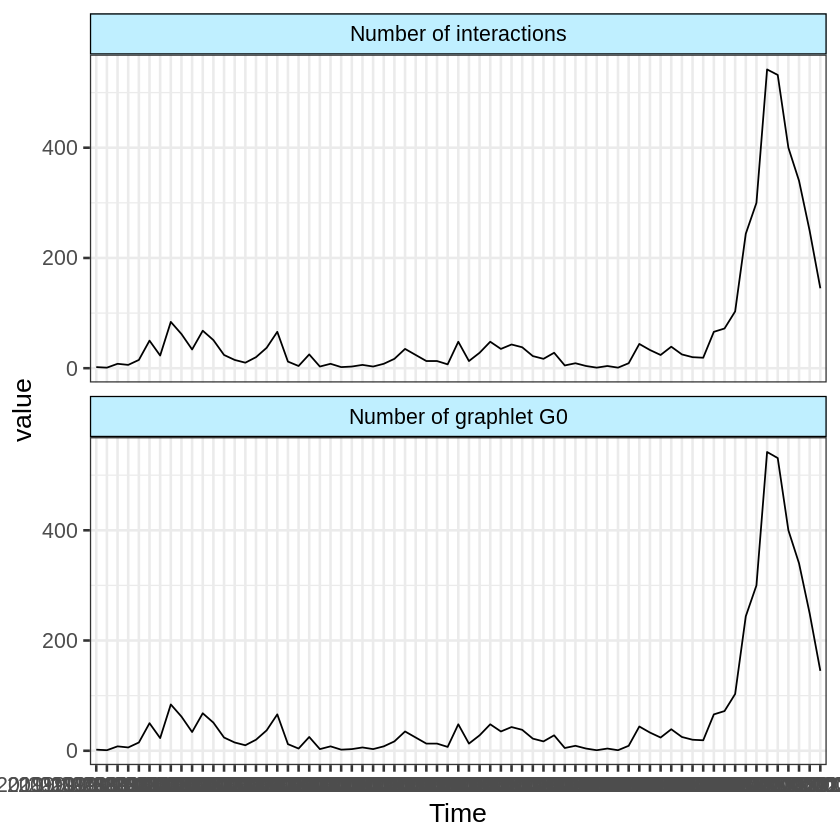

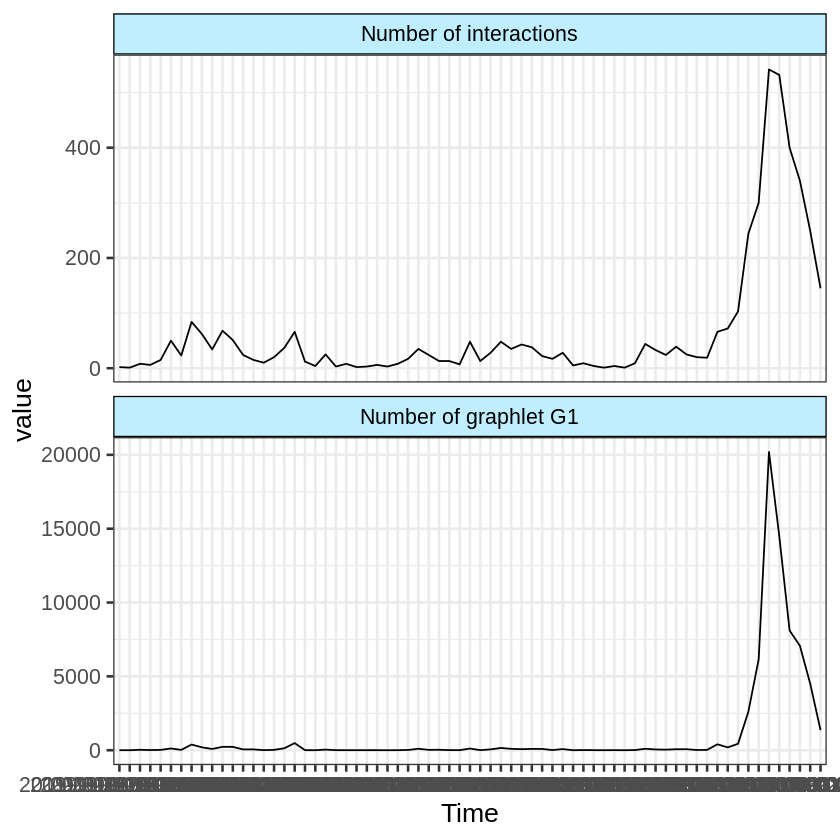

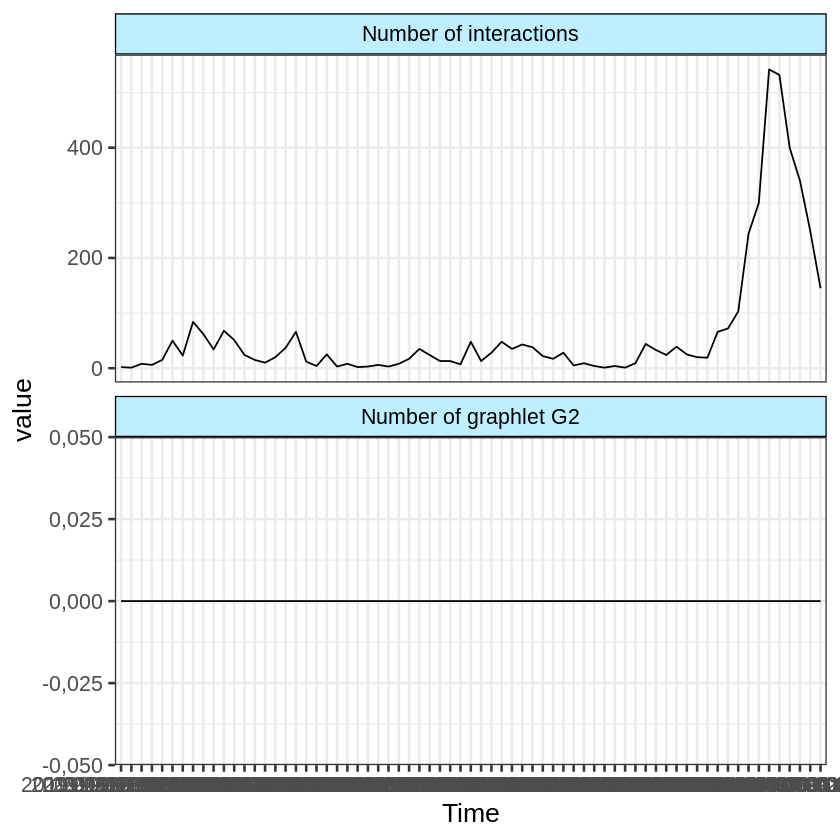

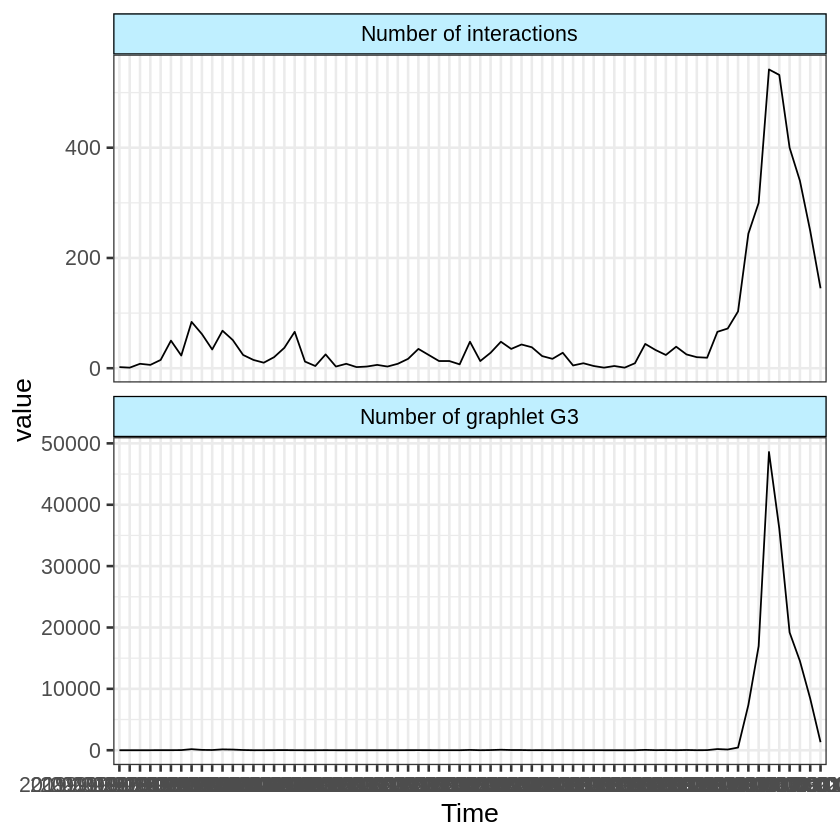

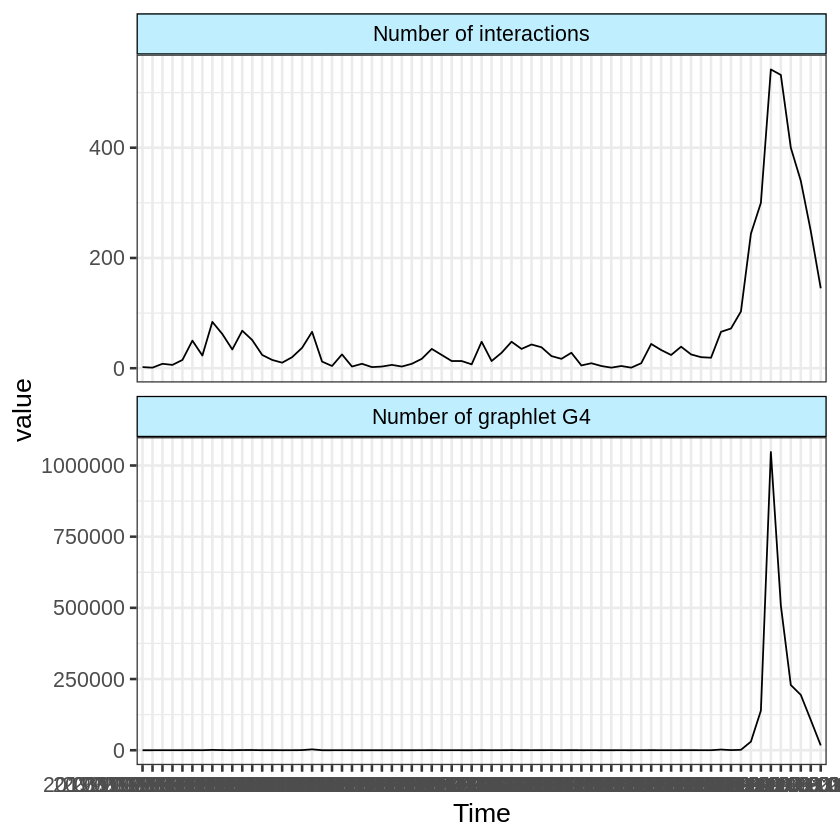

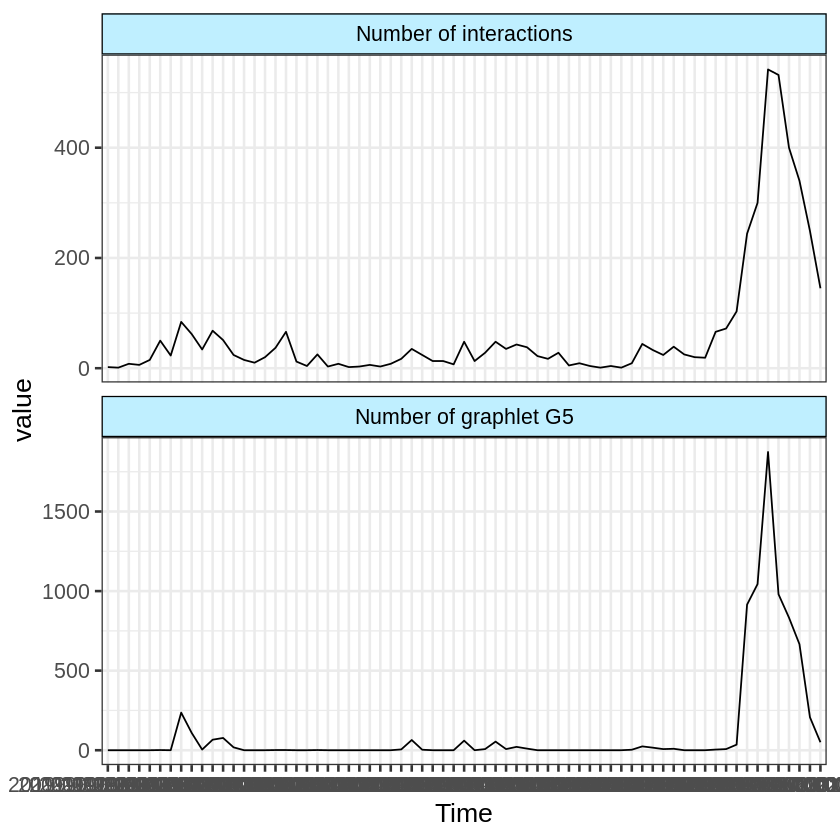

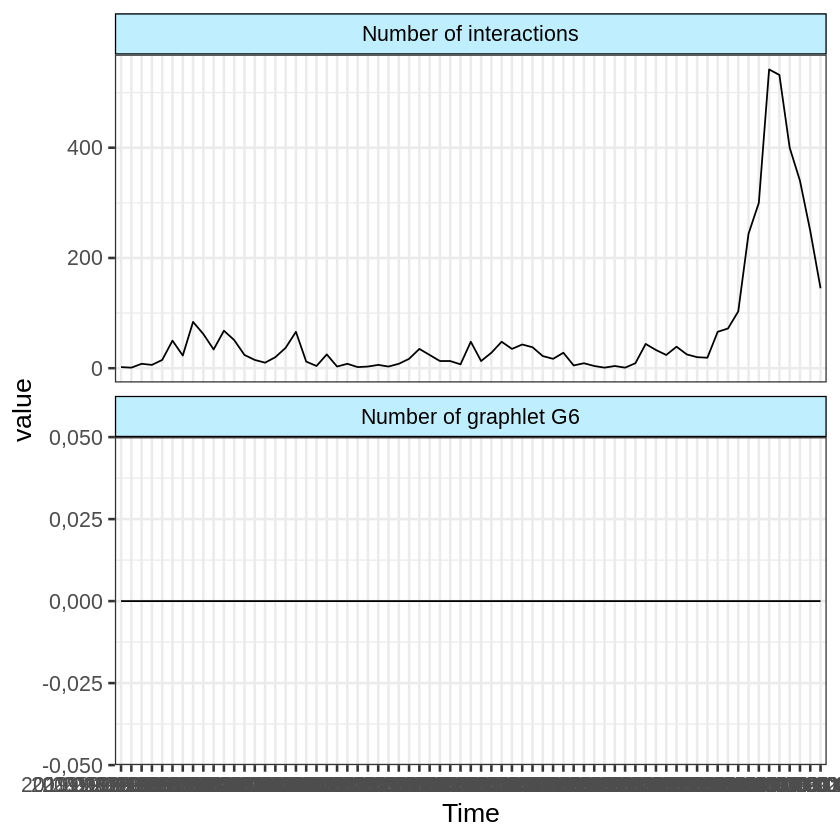

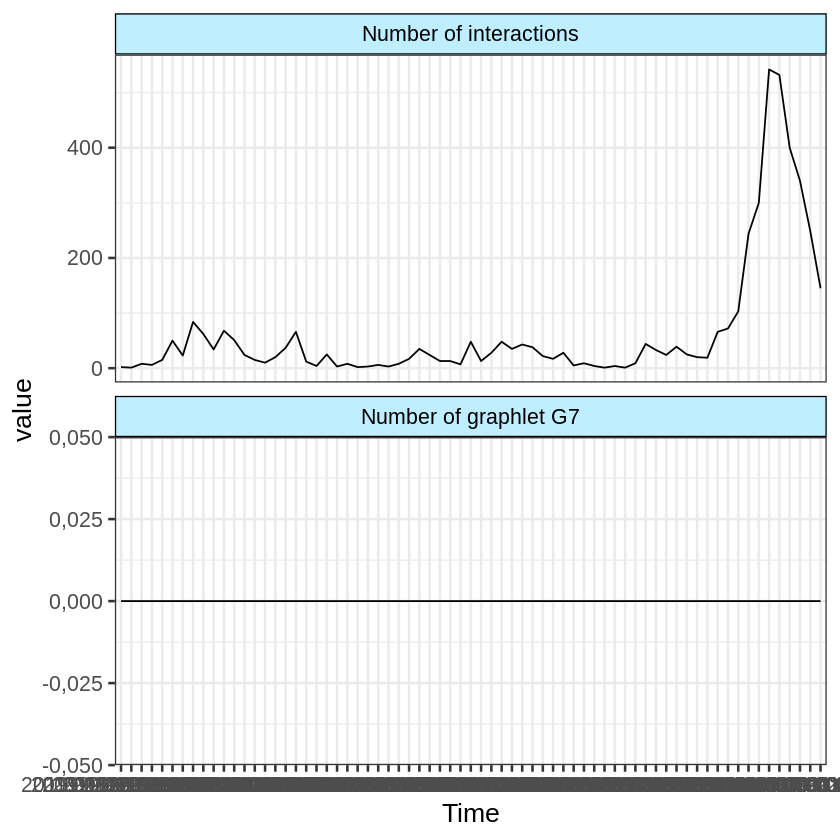

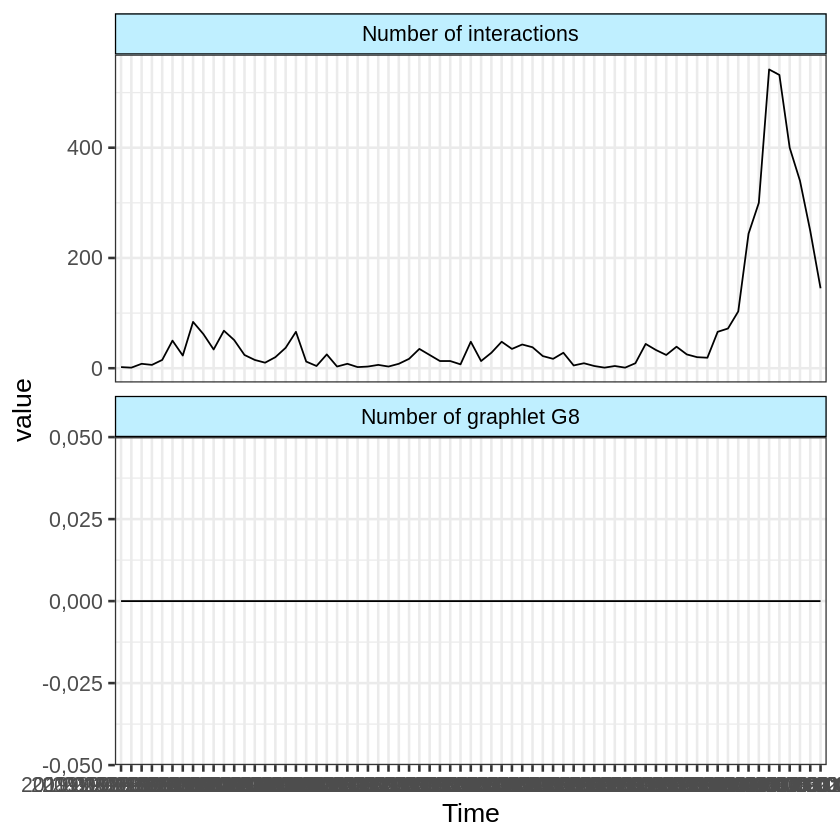

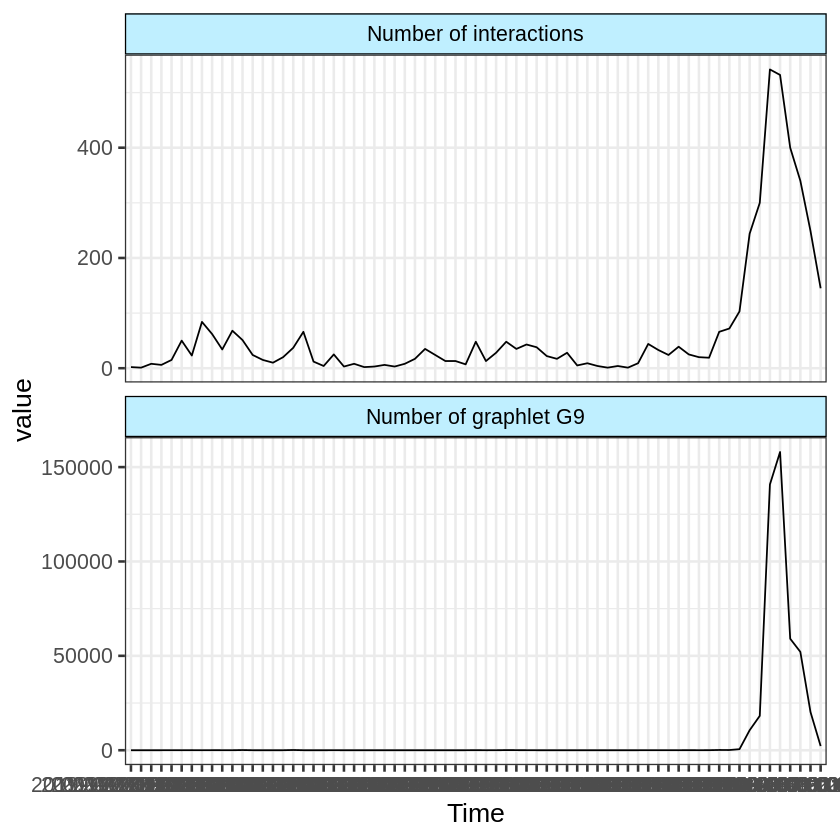

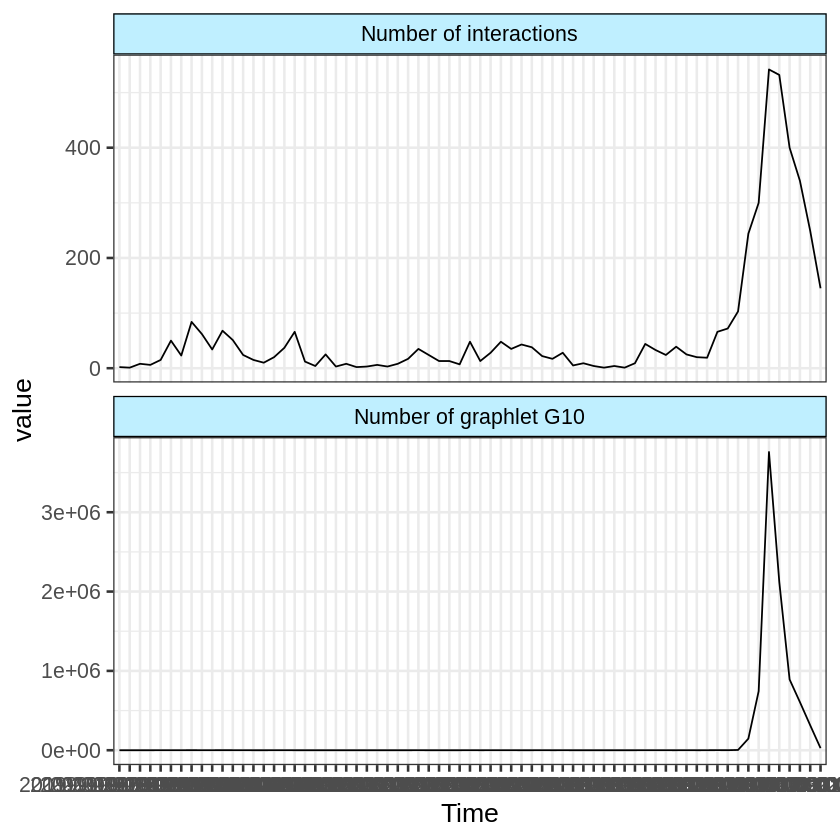

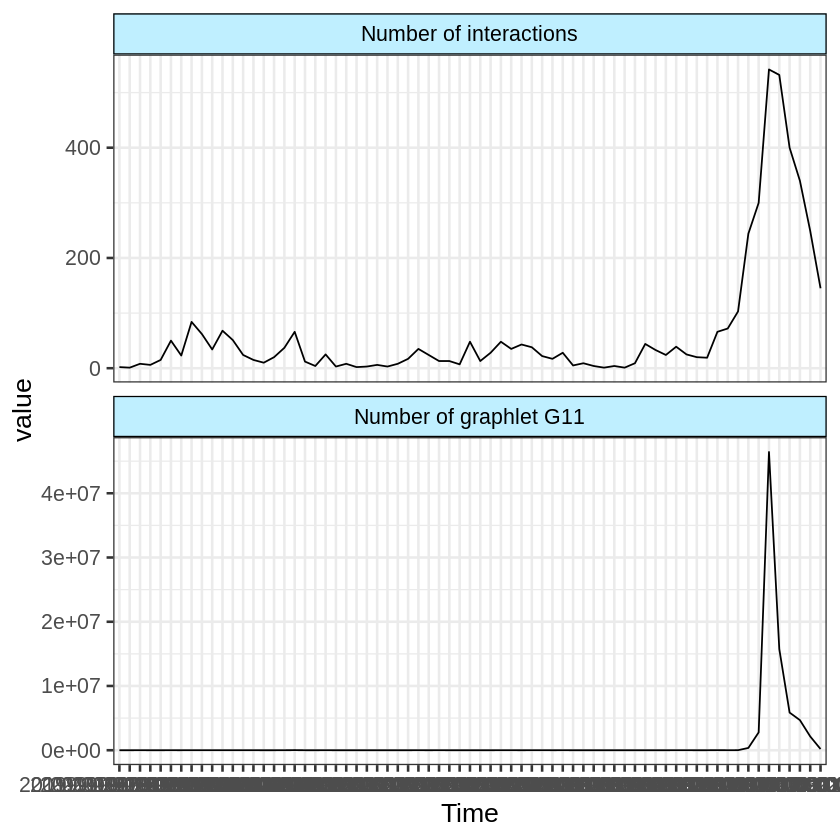

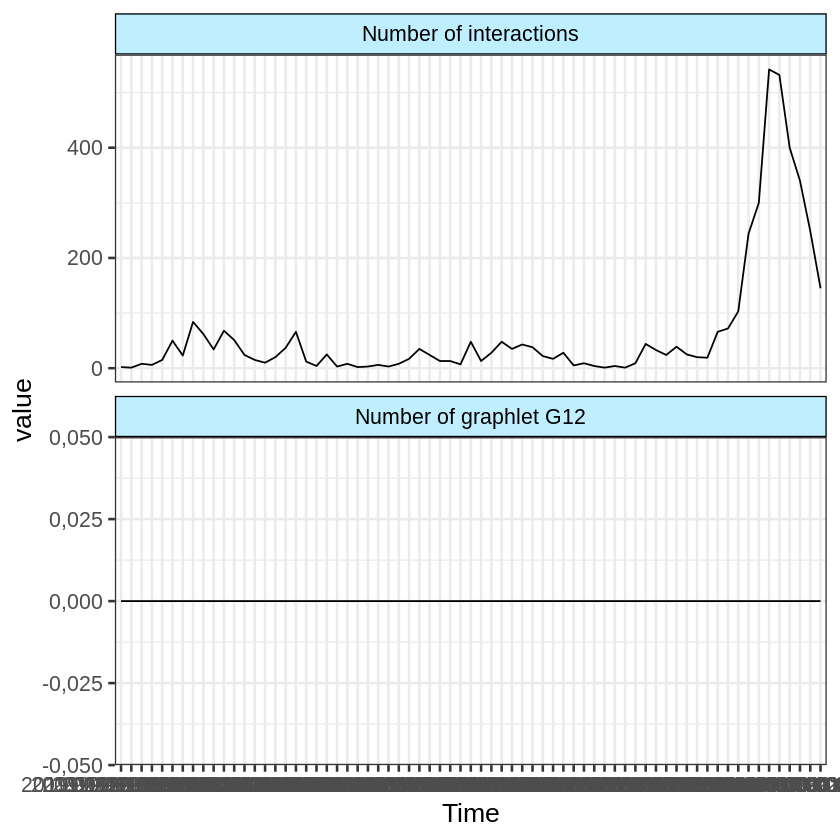

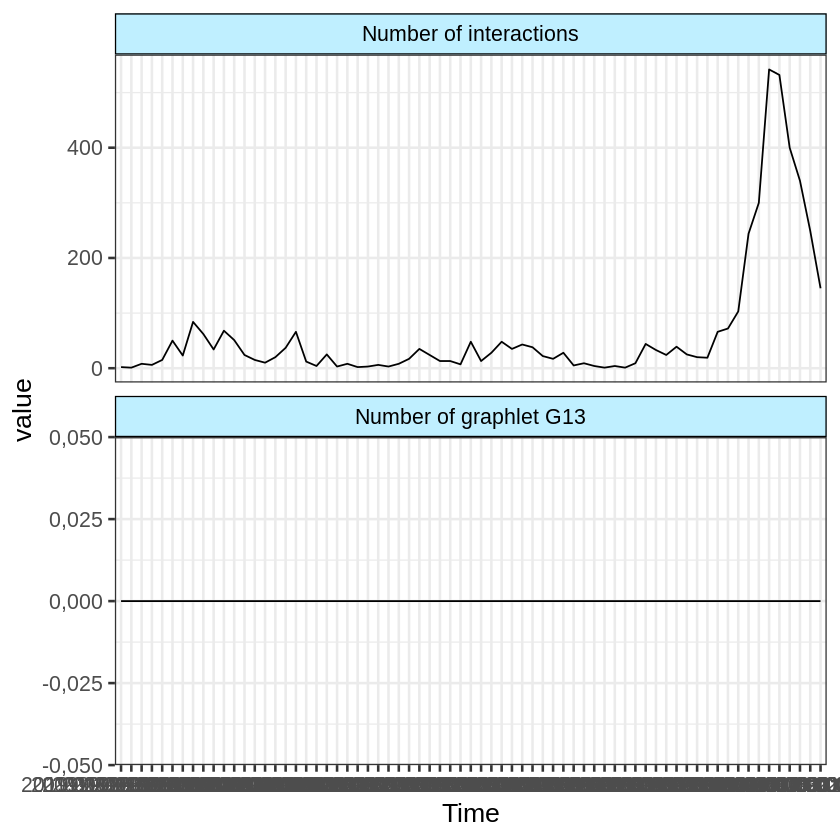

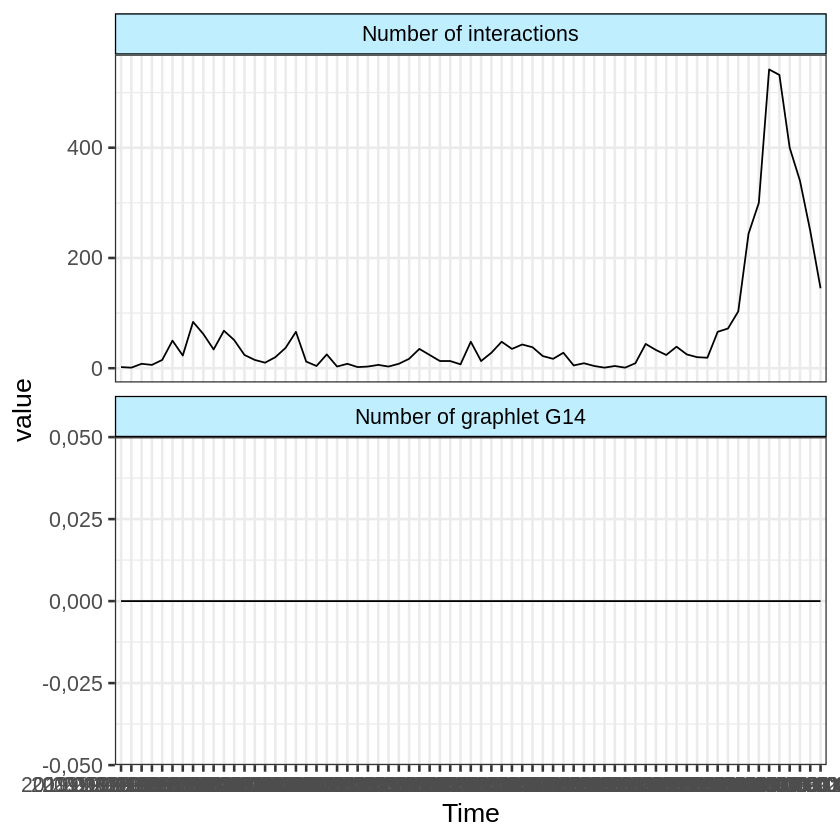

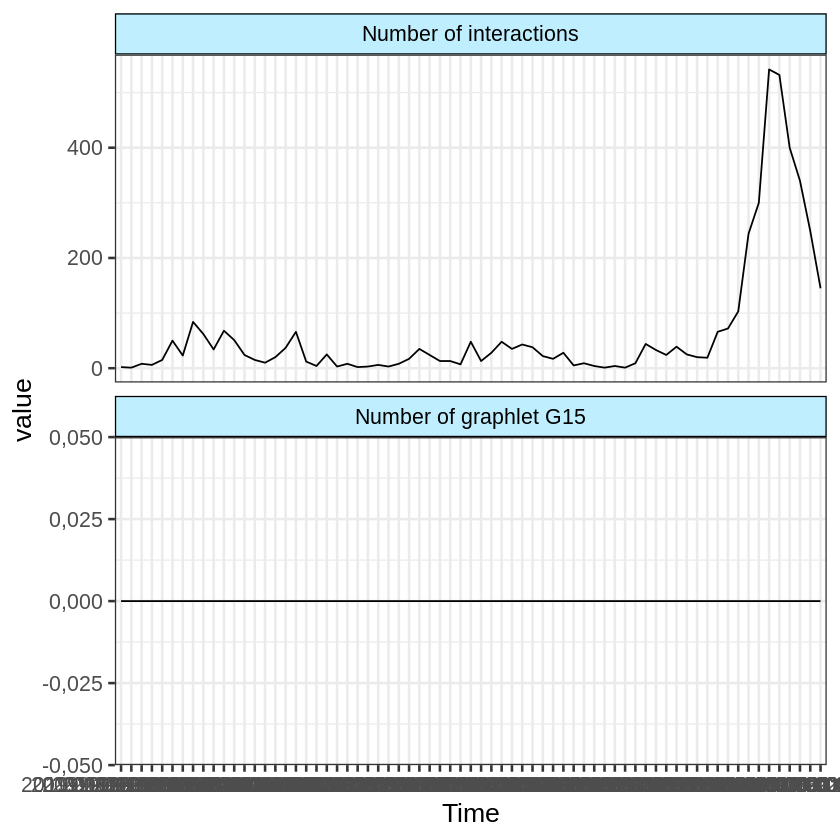

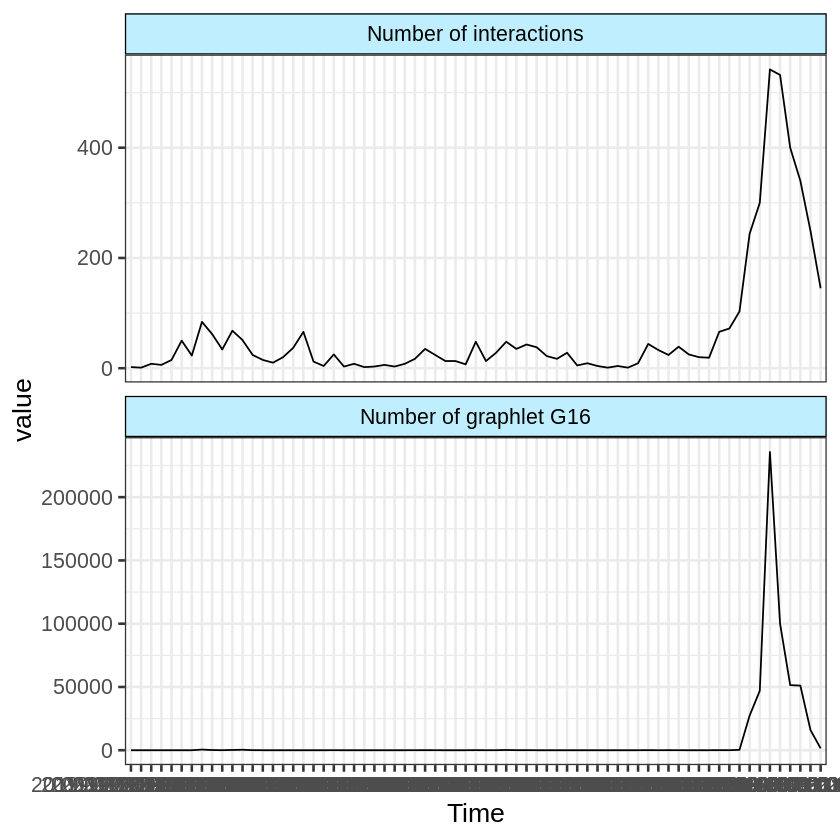

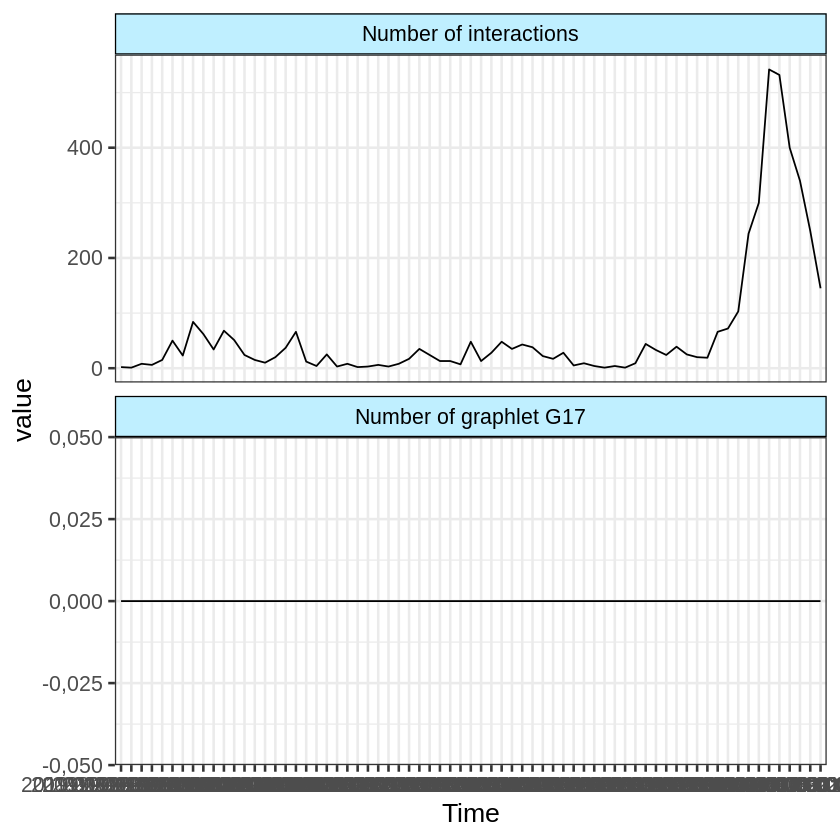

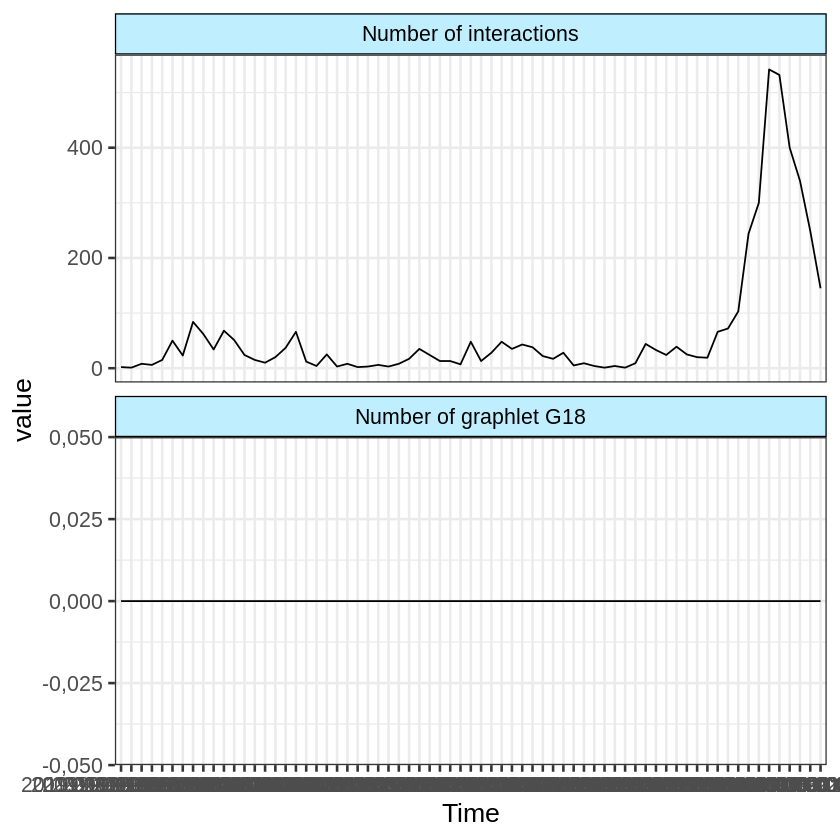

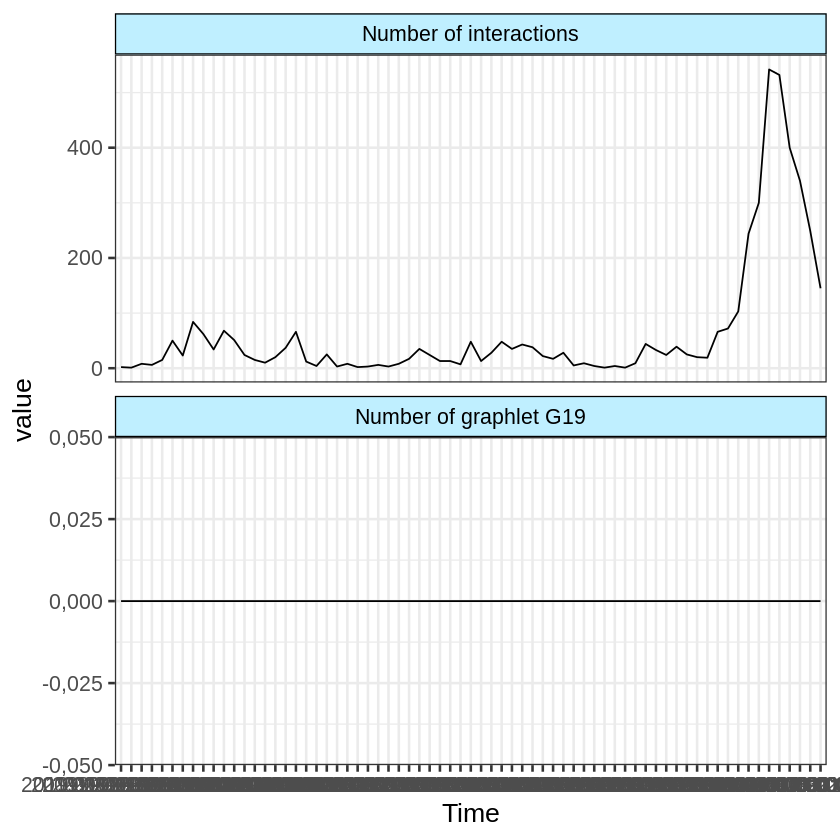

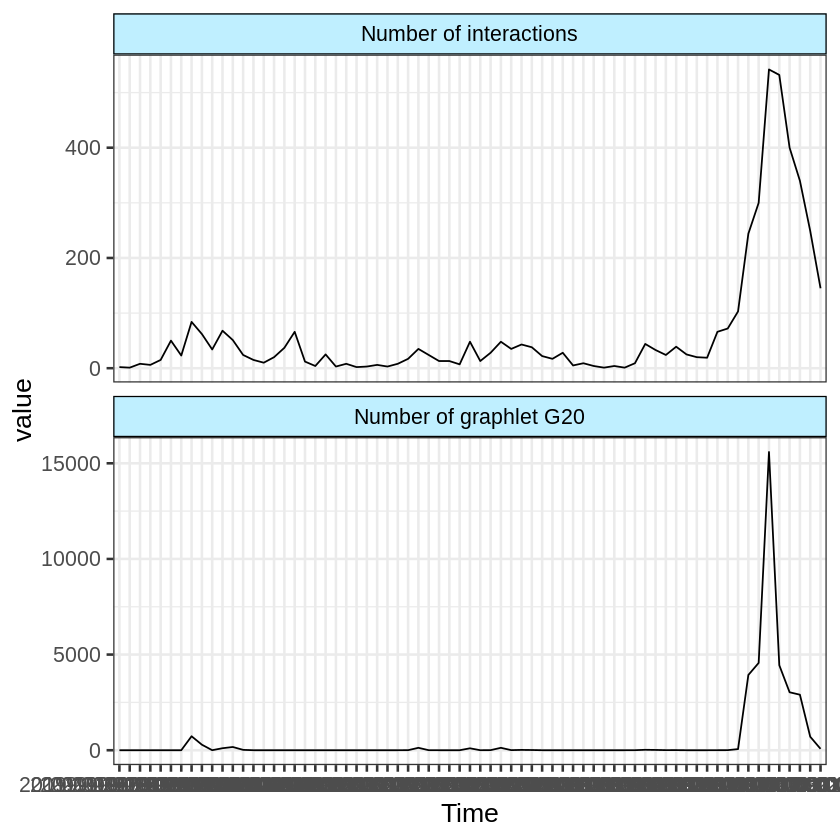

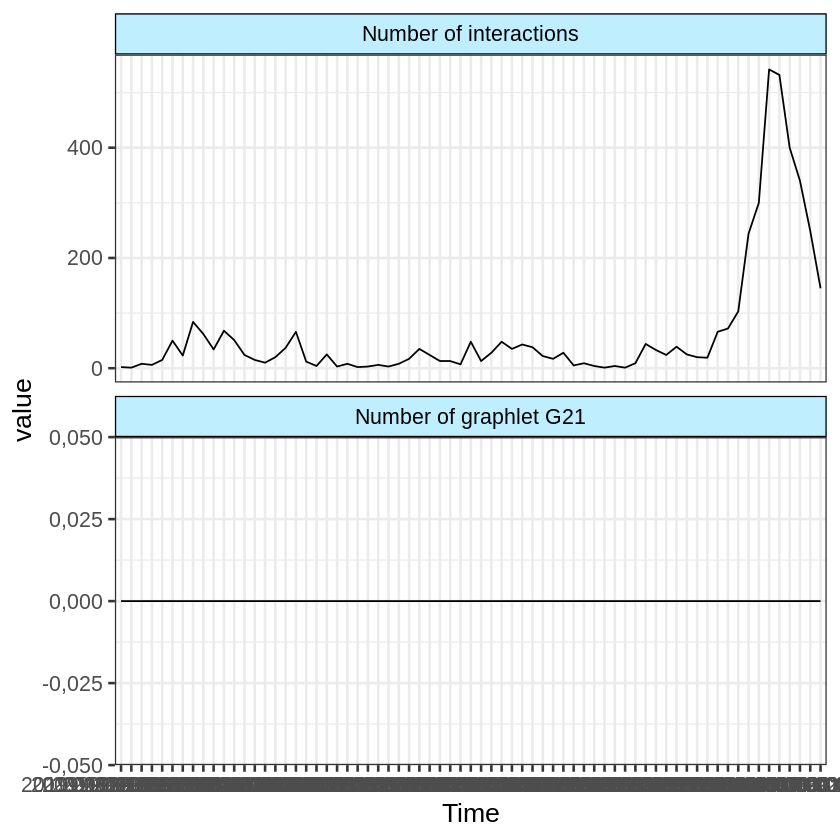

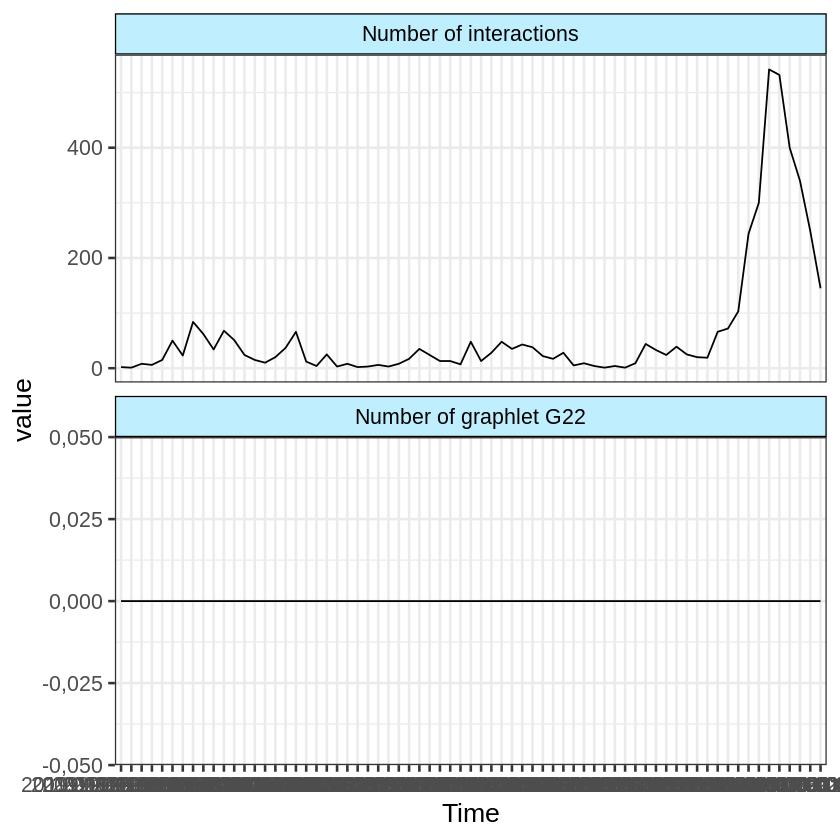

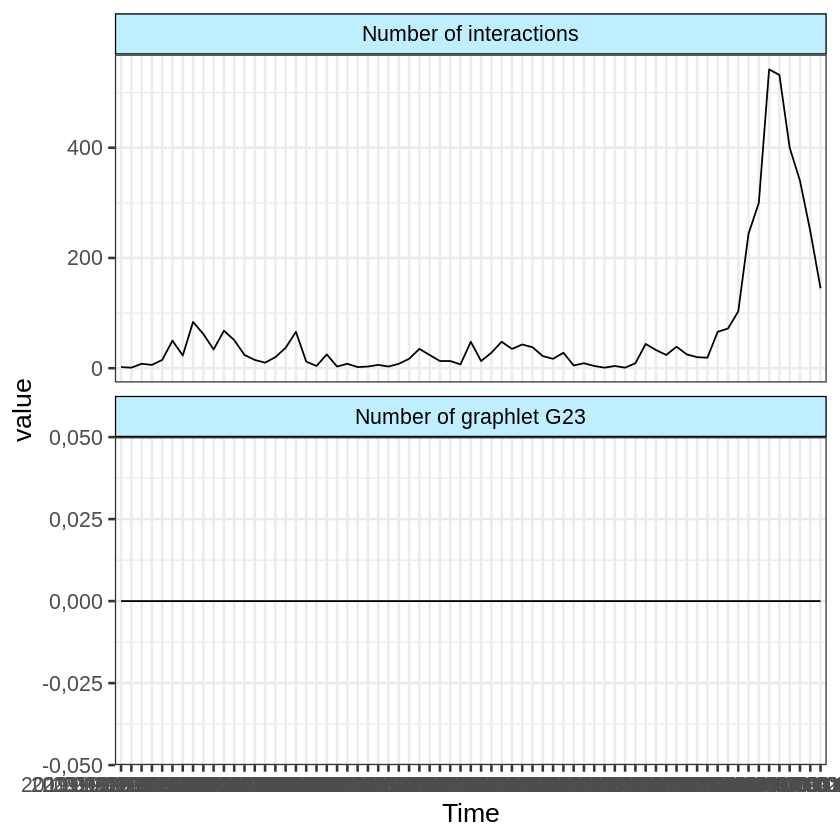

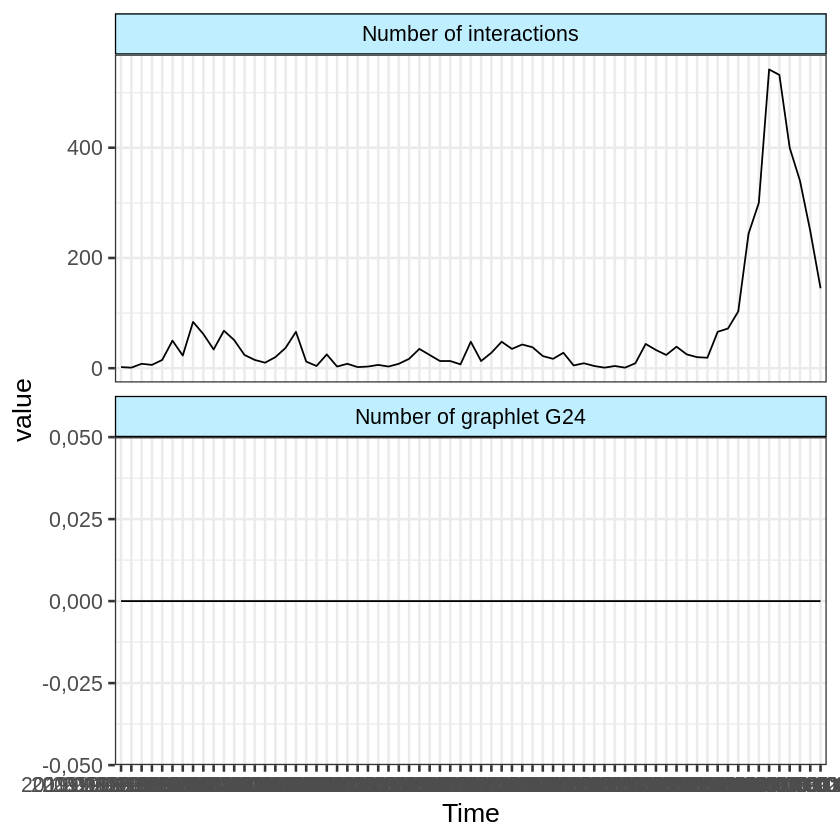

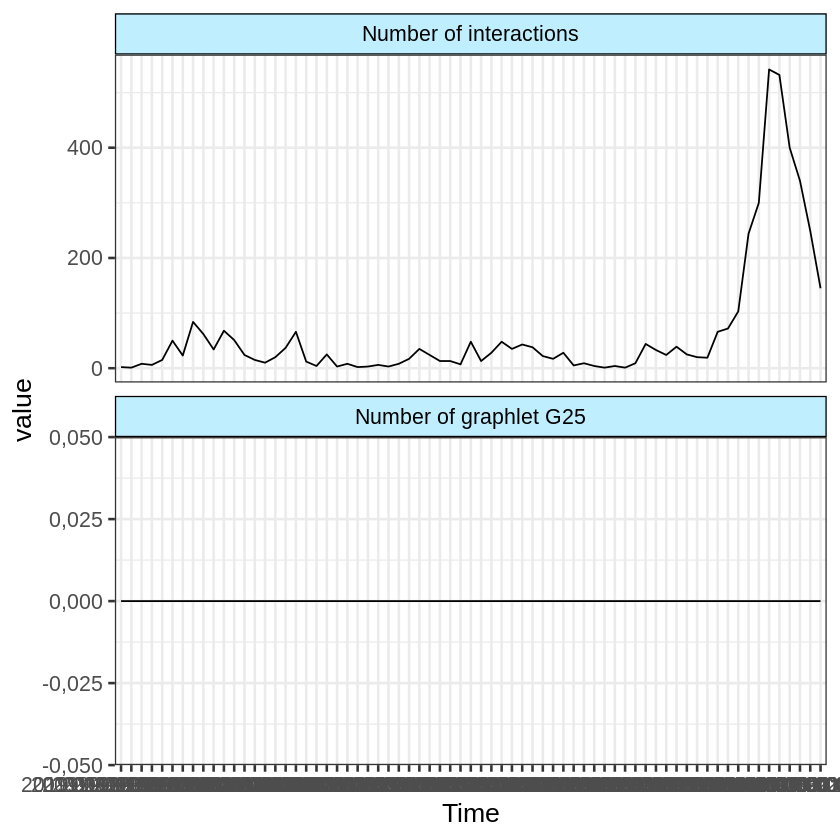

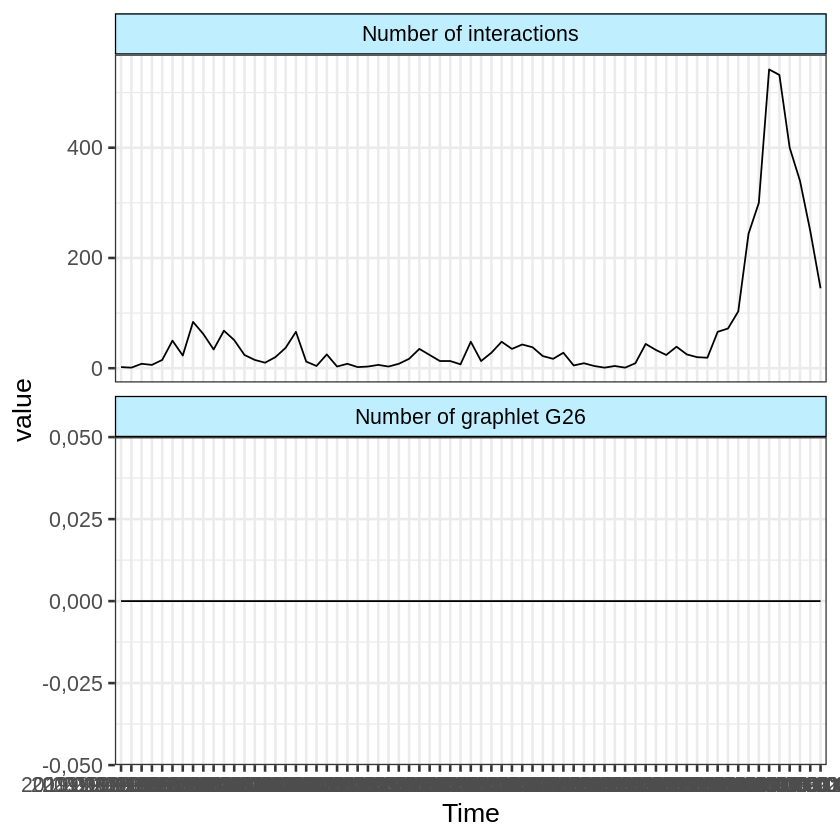

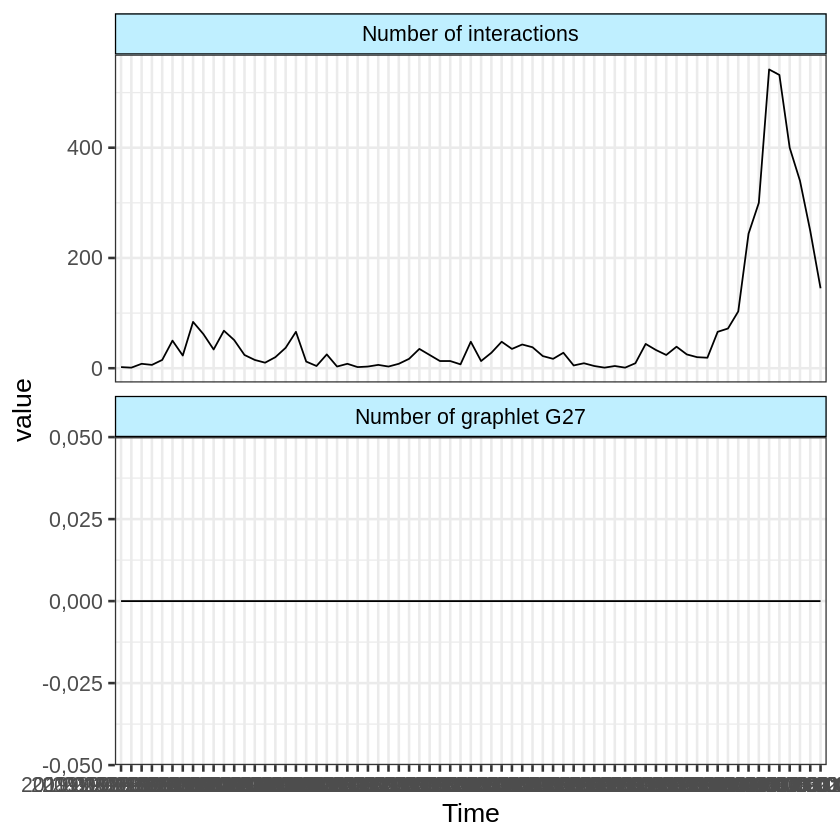

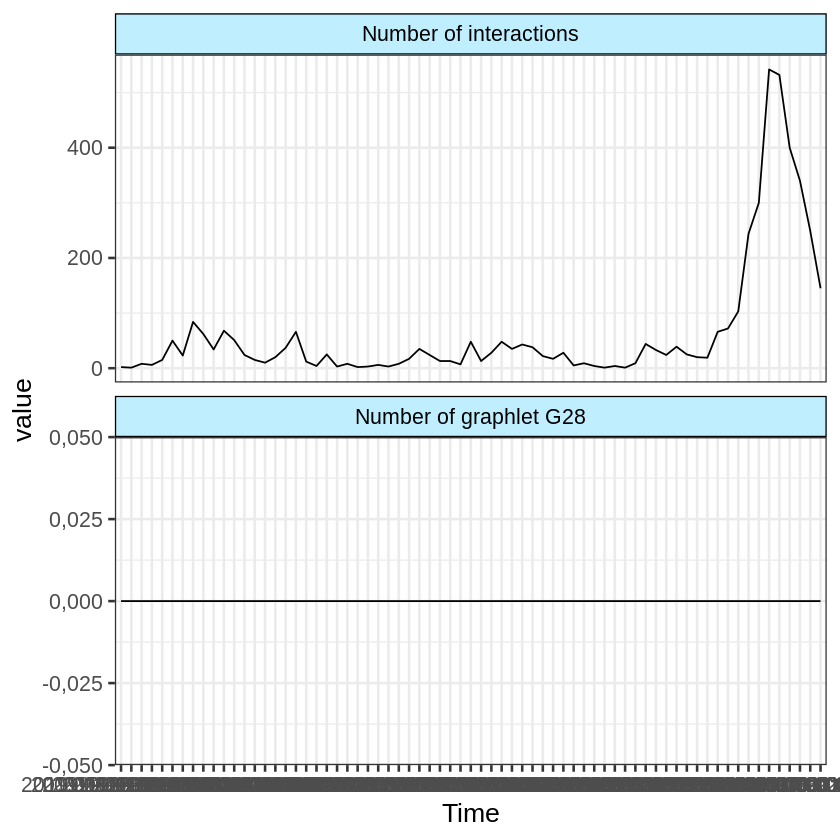

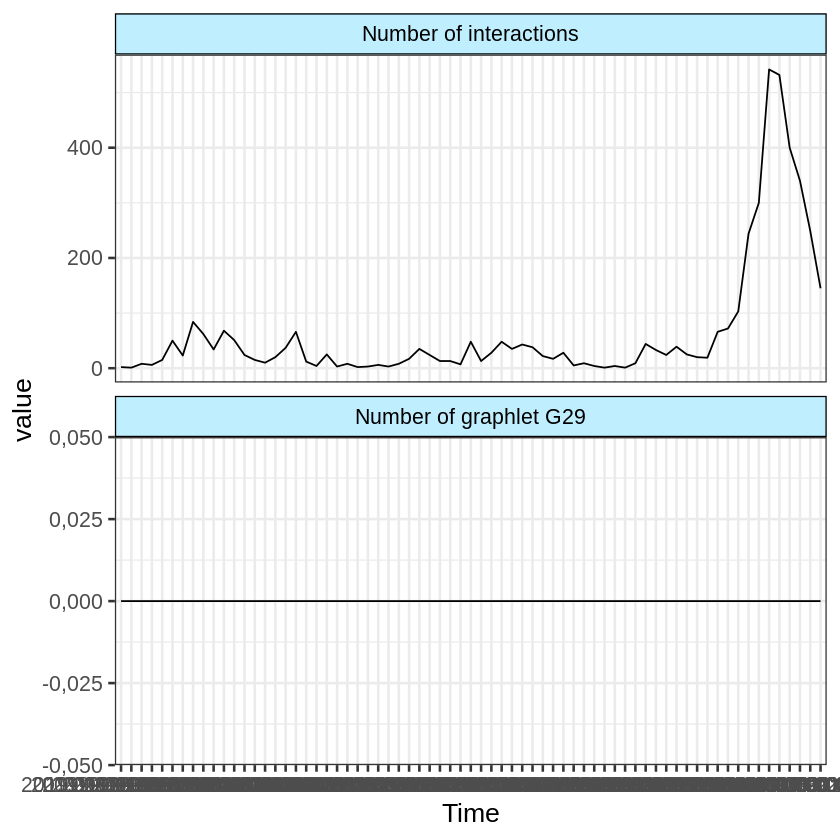

In [186]:

for (i in 1:30) {

print(ggplot(df_melt[[i]], aes(x = Time, y = value, group = 1)) + 
    geom_line() + 
    facet_wrap(~ variable, scales = 'free_y', ncol = 1)+
theme(legend.position = "none",
        strip.background = element_rect(colour="black",
                                        fill="lightblue1"))+
theme(strip.text = element_text(colour = 'black')))
 
} 

# Relative graphlet frequency distance - RGFD

## Apply the formula

In [187]:
rm(rgfd)
rgfd <- as.data.frame(df)

#calculate the sum of all initial graphlets number for each snapshot
rgfd$sumG <-  rowSums(rgfd[1:30])

# formula of RGFD = -log(Gi/Sum(Gi))
 

for (i in 1:30) {
    
    rgfd[,i] <- -log10(rgfd[,i]/rgfd$sumG)
    
}
head(rgfd)

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,⋯,G21,G22,G23,G24,G25,G26,G27,G28,G29,sumG
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-10-28 00:00:00,"0,1760913","0,4771213",Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,⋯,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,3
2019-10-28 01:00:00,"0,0000000",Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,⋯,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,1
2019-10-28 03:00:00,"1,3064250","0,7623570",Inf,Inf,"0,4613270",Inf,Inf,Inf,Inf,Inf,⋯,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,162
2019-10-28 05:00:00,"0,7132104","0,4913617",Inf,Inf,"0,4913617",Inf,Inf,Inf,Inf,Inf,⋯,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,31
2019-10-28 06:00:00,"0,7683914","0,6020600",Inf,"0,9444827","0,7683914",Inf,Inf,Inf,Inf,"0,9444827",⋯,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,88
2019-10-28 07:00:00,"1,2211533","0,8519375",Inf,"2,0170333","0,5399121","2,920123",Inf,Inf,Inf,Inf,⋯,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,Inf,832


In [188]:
rm(rgfd2)
rgfd2 <- as.data.frame(rgfd[ , !(names(rgfd) %in% "sumG")])

#remove infinite values
rgfd2 <- do.call(data.frame,lapply(rgfd2, function(x) replace(x, is.infinite(x),0)))
 
#keep the creation date as rownames 
rownames(rgfd2) = rownames(rgfd) 
                                   
#sum the calculated values as per the formula                          
rgfd2$RGFD <-  rowSums(rgfd2)

#monitor the evolution of RGFD values between snapshots(i.e. creation date)
head(rgfd2)

,G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,⋯,G21,G22,G23,G24,G25,G26,G27,G28,G29,RGFD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019-10-28 00:00:00,"0,1760913","0,4771213",0,"0,0000000","0,0000000","0,000000",0,0,0,"0,0000000",⋯,0,0,0,0,0,0,0,0,0,"0,6532125"
2019-10-28 01:00:00,"0,0000000","0,0000000",0,"0,0000000","0,0000000","0,000000",0,0,0,"0,0000000",⋯,0,0,0,0,0,0,0,0,0,"0,0000000"
2019-10-28 03:00:00,"1,3064250","0,7623570",0,"0,0000000","0,4613270","0,000000",0,0,0,"0,0000000",⋯,0,0,0,0,0,0,0,0,0,"2,8945260"
2019-10-28 05:00:00,"0,7132104","0,4913617",0,"0,0000000","0,4913617","0,000000",0,0,0,"0,0000000",⋯,0,0,0,0,0,0,0,0,0,"2,4883255"
2019-10-28 06:00:00,"0,7683914","0,6020600",0,"0,9444827","0,7683914","0,000000",0,0,0,"0,9444827",⋯,0,0,0,0,0,0,0,0,0,"6,1386223"
2019-10-28 07:00:00,"1,2211533","0,8519375",0,"2,0170333","0,5399121","2,920123",0,0,0,"0,0000000",⋯,0,0,0,0,0,0,0,0,0,"9,6111706"


# Cross-Correlation

## Interactions time series vector

In [189]:
interactions_ts <- ts(count_interactions[ , c( 2)] )

## Graphlets time series vectors

Create time series of one column each for the 30 graphlets

In [190]:
rm(graphlet_g)
rm(graphlet_ts)
graphlet_g <- list()
graphlet_ts <- list()

for (i in 1:ncol(df_normalise)){

    graphlet_g[[i]] <- df_normalise[ , c(i)]  
    graphlet_ts[[i]] <- ts(graphlet_g[[i]])
        
}

Remove the columns with NAN values, to prepare for correlation method

In [191]:
rm(graphlets_ts)
graphlets_ts <- do.call("cbind", graphlet_g)

graphlets_ts <- graphlets_ts[,colSums(is.na(graphlets_ts))<nrow(graphlets_ts)]

## Cross Correlation calculation between initial time series and Graphlet X time series

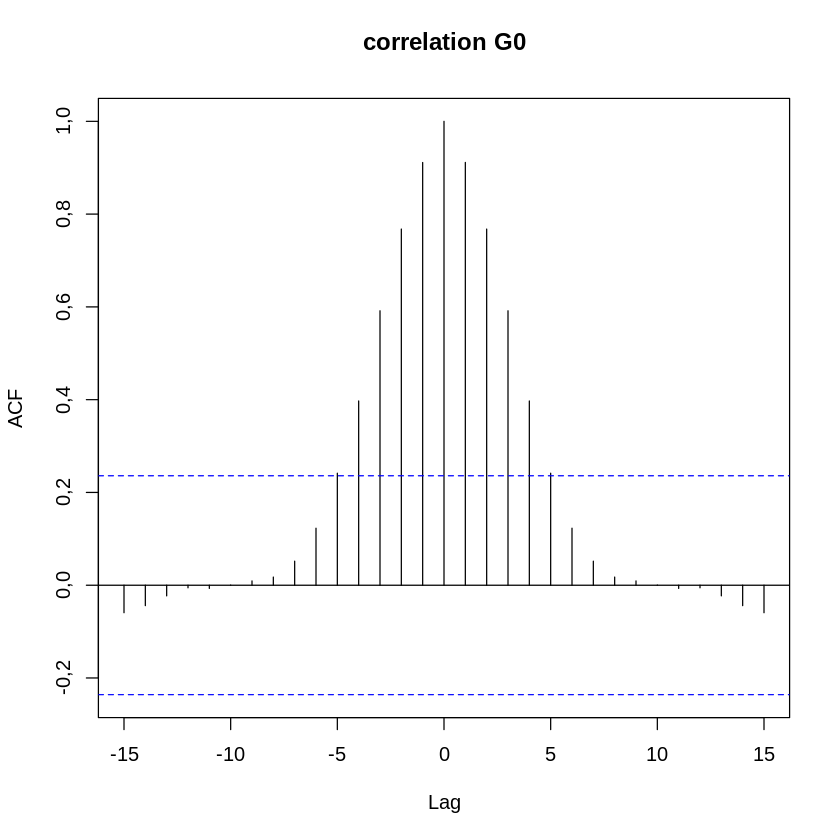

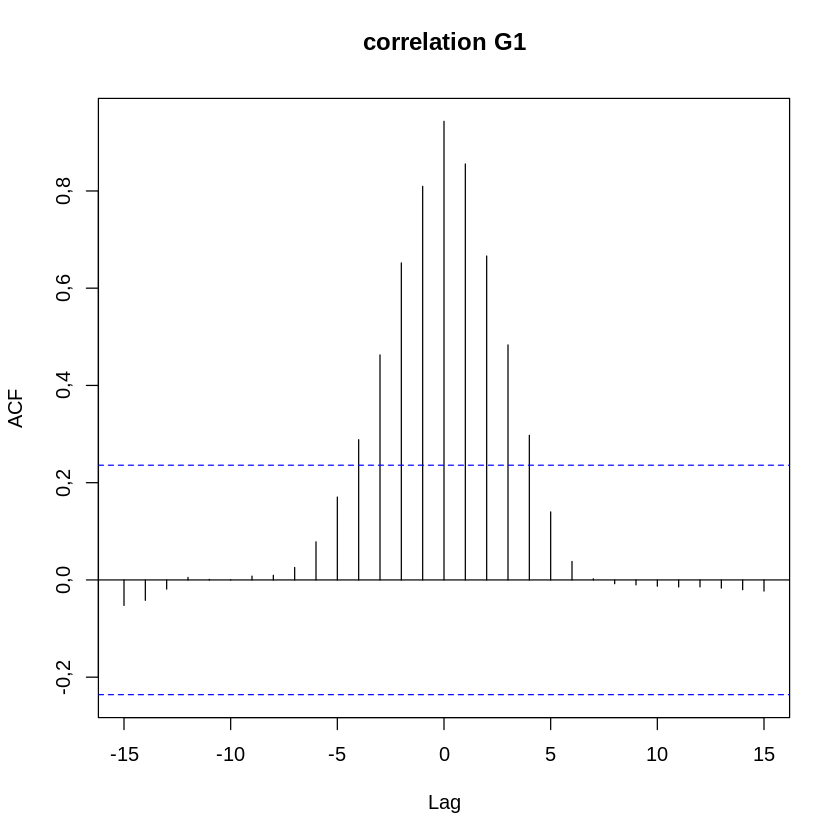

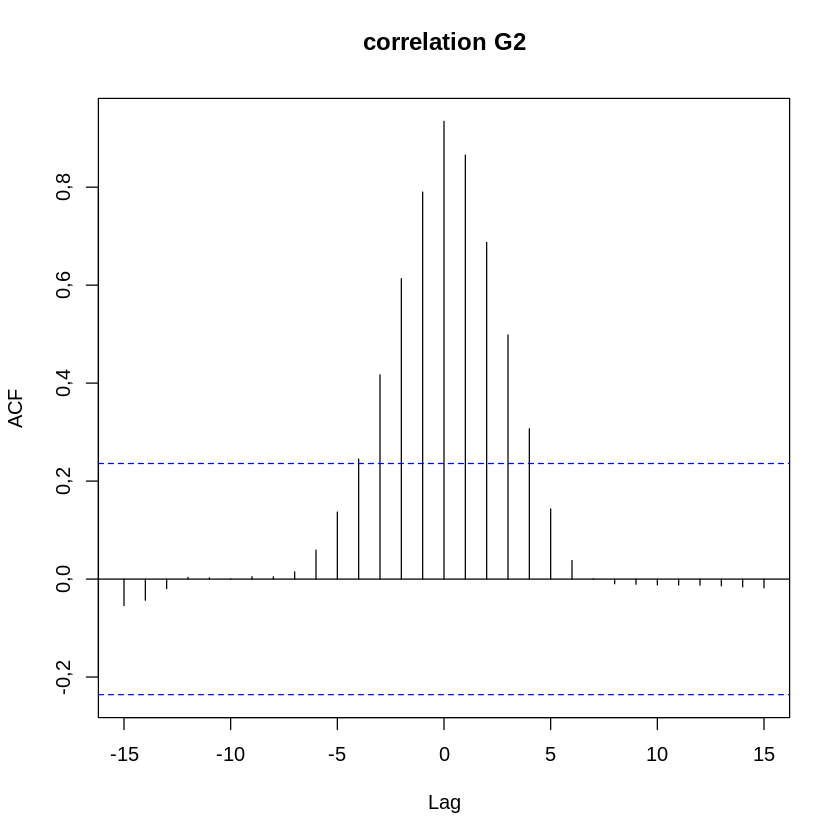

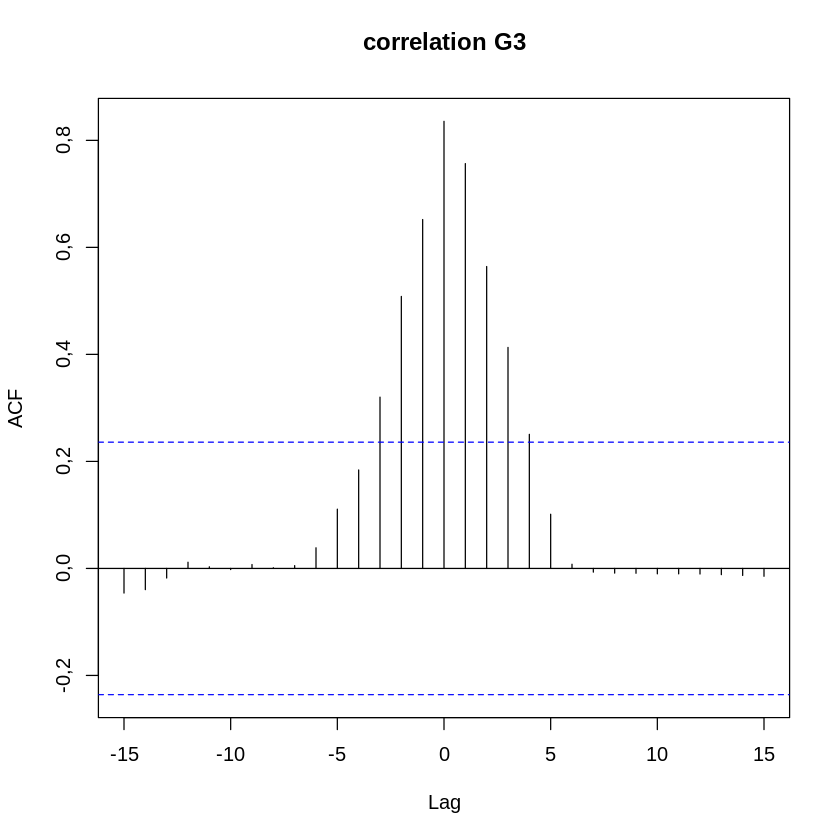

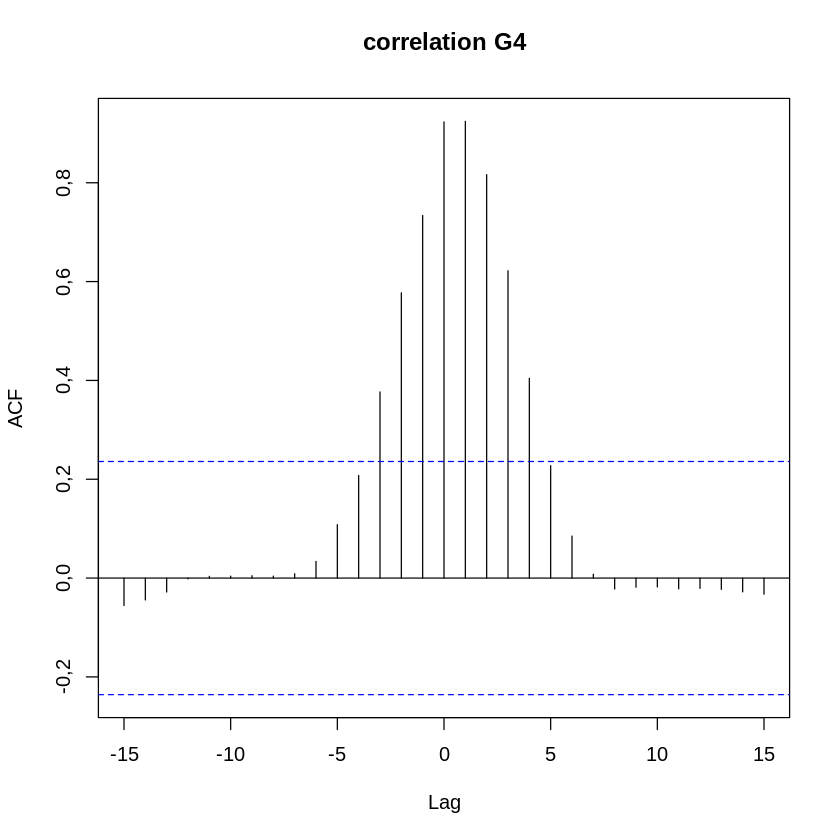

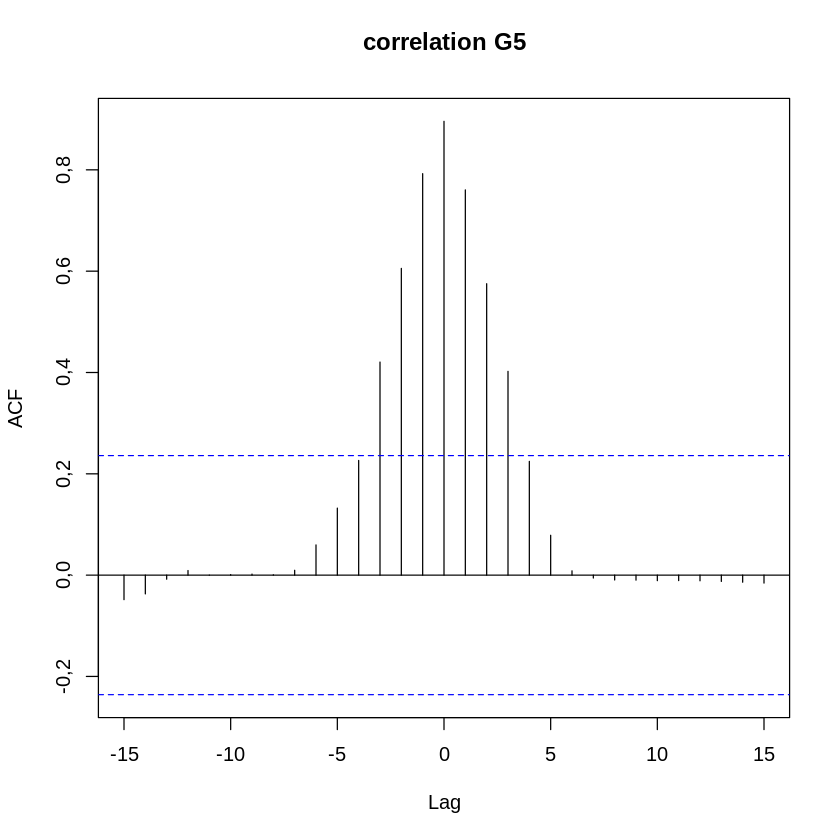

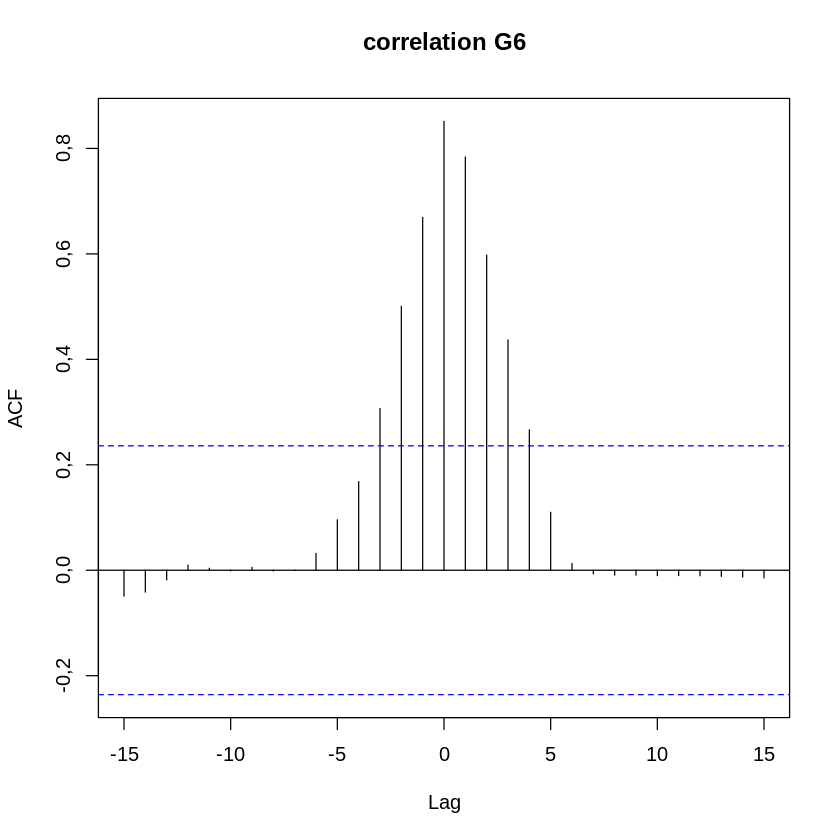

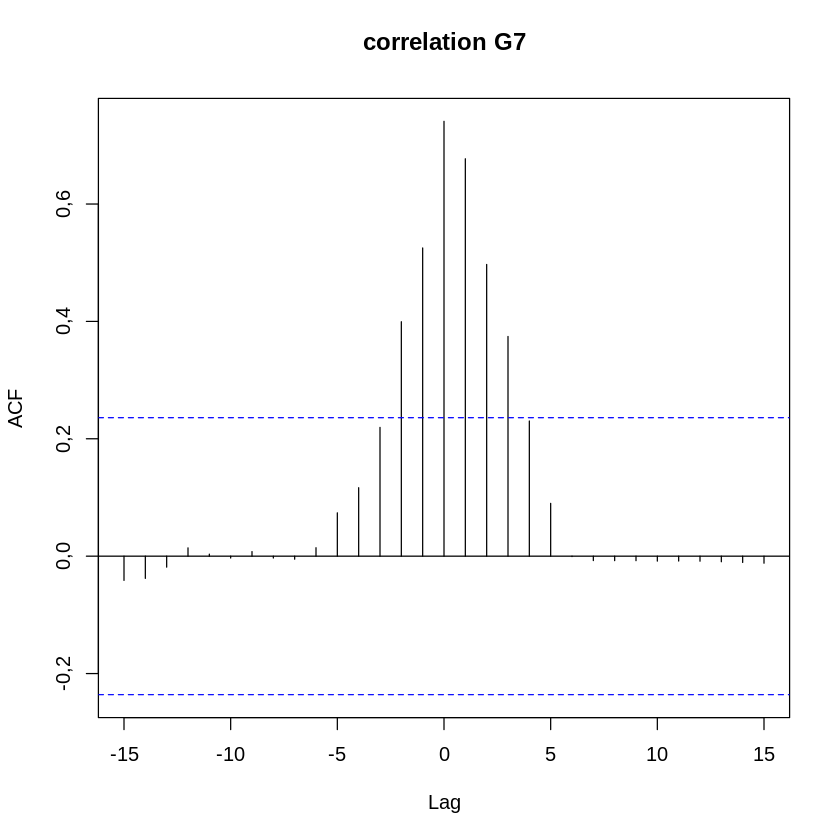

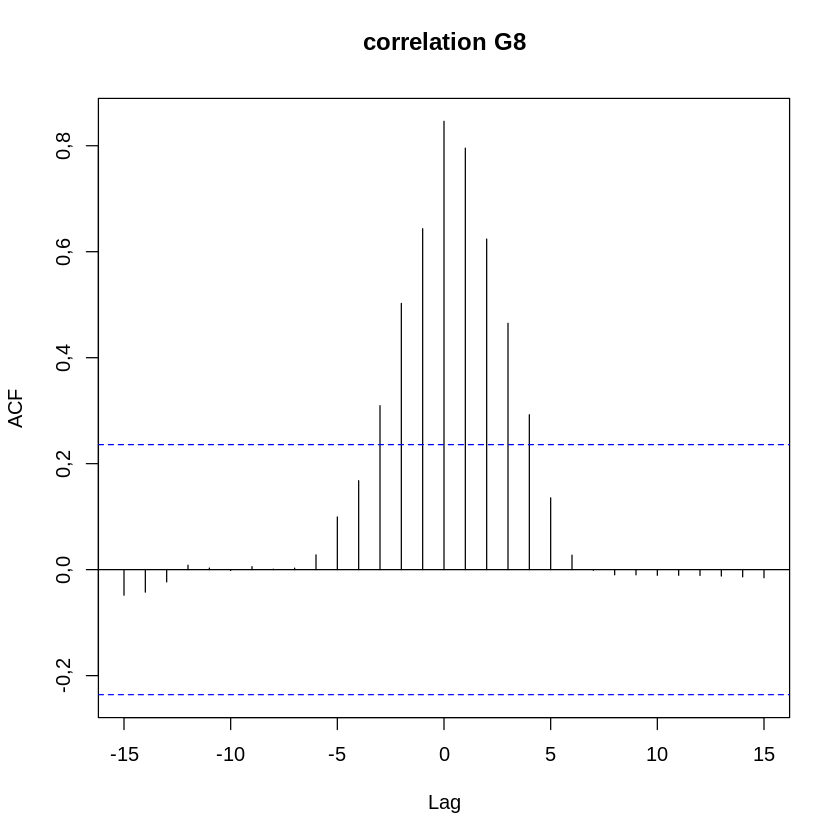

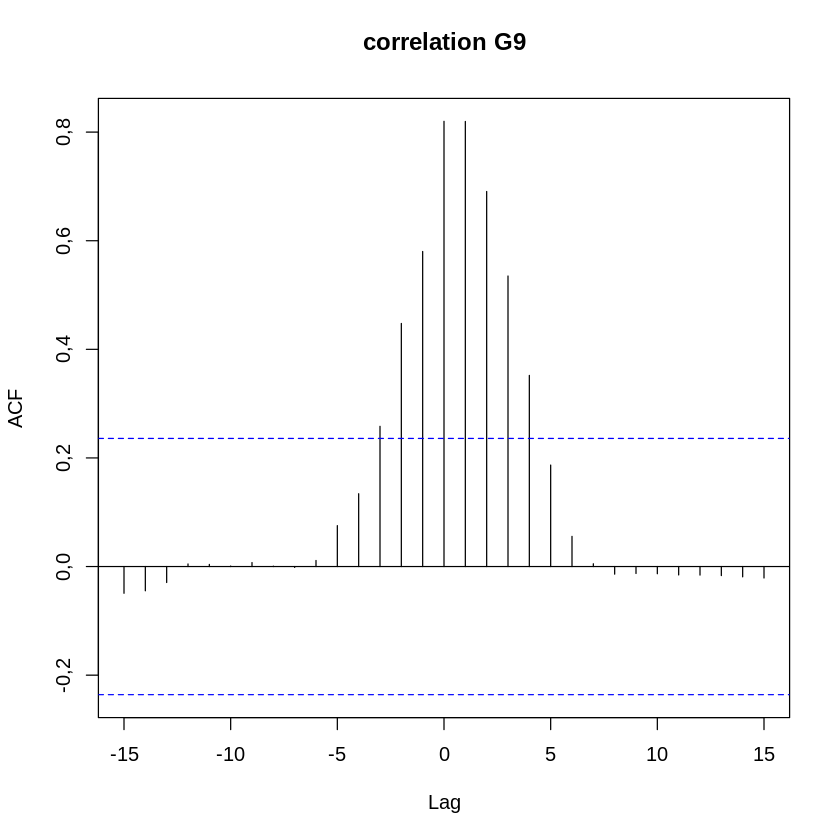

In [192]:
rm(ccfvalues)
rm(graphlets)
ccfvalues <- list()
graphlets <- list()

# the lags are of one hour, per snaphots used
for (i in 1:ncol(graphlets_ts)){

     graphlets[[i]] <- graphlets_ts[ , c(i)]  
     
     #calculate the ccf method for the filled columns of the graphlets data frame
     ccfvalues[[i]] = ccf(count_interactions[ , c( 2)], graphlets[[i]], 
                     main = paste("correlation G", i-1, sep="")) 

}

# Count orbits per node

In [193]:
rm(orbite_per_node)
rm(orbite_per_node_out)
rm(nodes_list)

orbite_per_node <- list()
orbite_per_node_out <- list()
nodes_list <- list()


for (datee in unique(datafile$time_interval)) { 
   

    orbite_per_node[[datee]] <-  count_orbits_per_node(simplify(interaction_snap[[datee]], 
                                                                    remove.multiple = T,
                                                                    remove.loops = F),
                                                                    5)
  
     
     nodes_list[[datee]] <- rownames(orbite_per_node[[datee]])
    
    # mettre le résultat de décomposition sous forme de colonnes du jour de la période, avec le noeud puis le nombre des ses orbits Oà à O72
      
    orbite_per_node_out[[datee]] <- cbind(datee,nodes_list[[datee]],orbite_per_node[[datee]])
    
    colnames(orbite_per_node_out[[datee]]) <- c("creation_timestamp","node","O0","O1","O2","O3","O4","O5","O6","O7","O8","O9","O10","O11","O12","O13","O14",
                                             "O15","O16","O17","O18","O19","O20","O21","O22","O23","O24","O25","O26","O27","O28","O29",
                                             "O30","O31","O32","O33","O34","O35","O36","O37","O38","O39","O40","O41","O42","O43","O44",
                                             "O45","O46","O47","O48","O49","O50","O51","O52","O53","O54","O55","O56","O57","O58","O59",
                                             "O60","O61","O62","O63","O64","O65","O66","O67","O68","O69","O70","O71","O72")

   rownames(orbite_per_node_out[[datee]]) <- NULL
    
}
#join all the results in a new dataframe, using rbind
out_df <- do.call("rbind",orbite_per_node_out)
head(out_df)

creation_timestamp,node,O0,O1,O2,O3,O4,O5,O6,O7,⋯,O63,O64,O65,O66,O67,O68,O69,O70,O71,O72
436727,111115287,2,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
436727,2222991,1,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
436727,2222890216,1,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
436728,111115481,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
436728,22220323,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
436730,111171495080243200,8,0,28,0,0,0,0,56,⋯,0,0,0,0,0,0,0,0,0,0
